In [1]:
import numpy as np
import torch
import tensorflow as tf
import gym
import sys
from collections import deque
import random

In [2]:
from explorerl.utils import *
from explorerl.agents import *
from explorerl.DQN import *

## DQN Tensorflow

In [3]:
env = gym.make('CartPole-v0')

In [4]:
e = Env_Wrapper(env)

In [5]:
d = DQNTF()

  0%|          | 0/200 [00:00<?, ?it/s]

Model Created!


Epsilon : 4.778667792722538e-44, Num Steps : 147, Avg Reward with Window Size 25 : 137.4: 100%|██████████| 200/200 [1:52:24<00:00, 33.72s/it]       
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


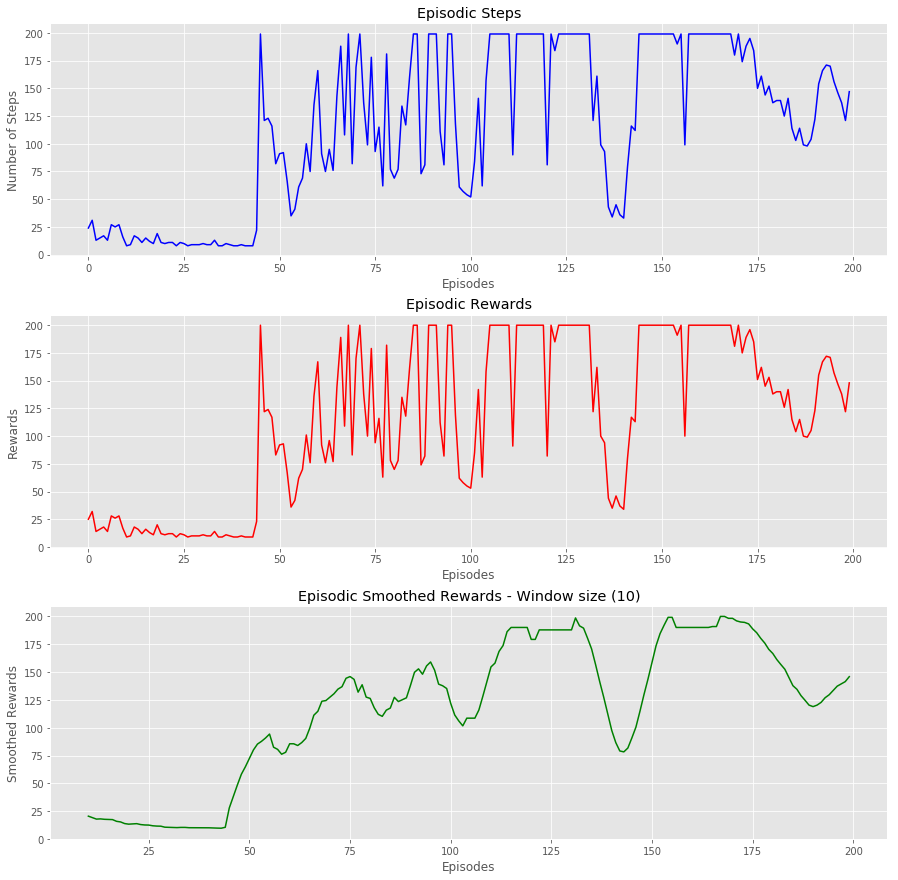

In [6]:
stats = e.train(d,episodes=200,train_episodal=False)

Total reward for episode 0: 140.0



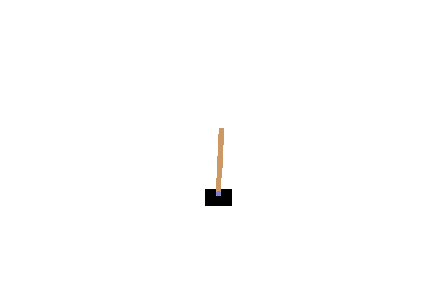
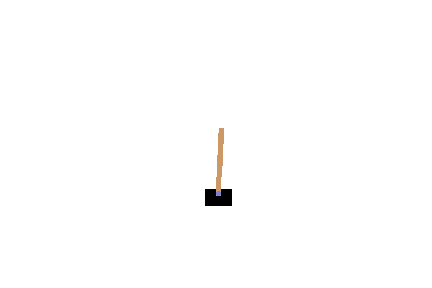
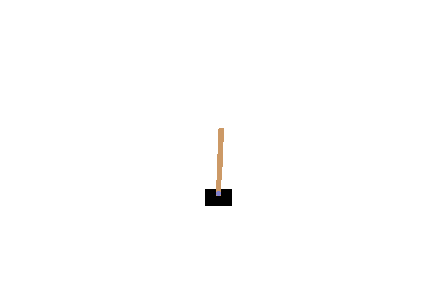
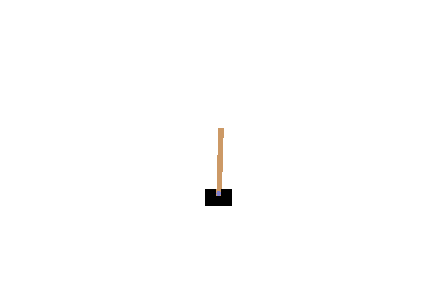
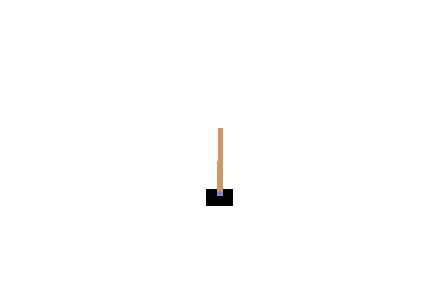
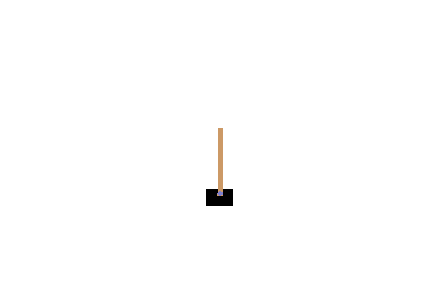
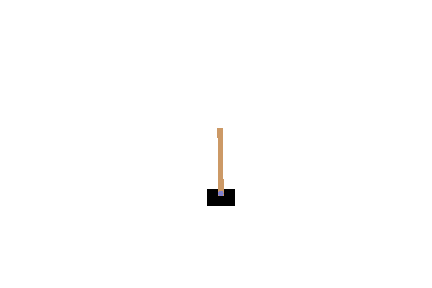
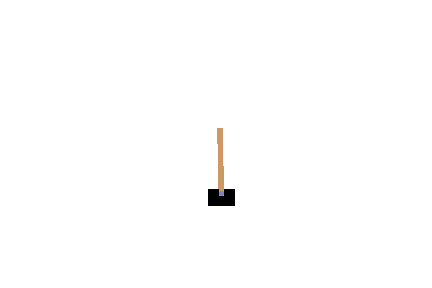
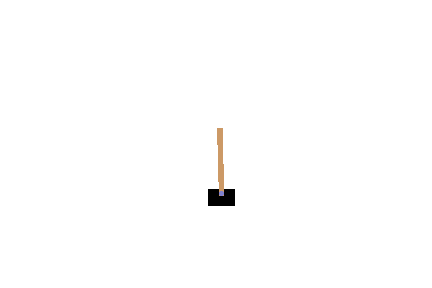
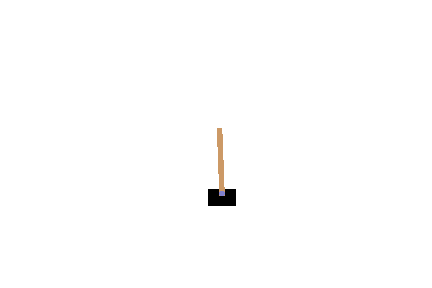
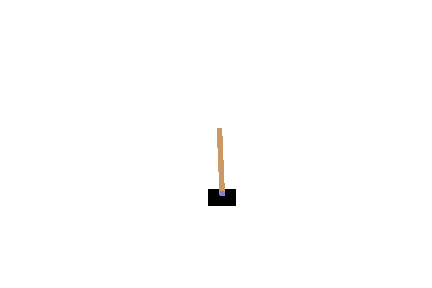
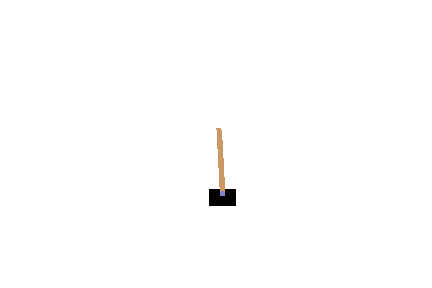
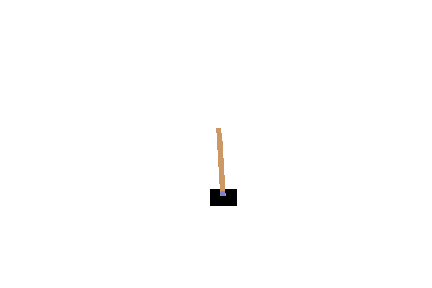
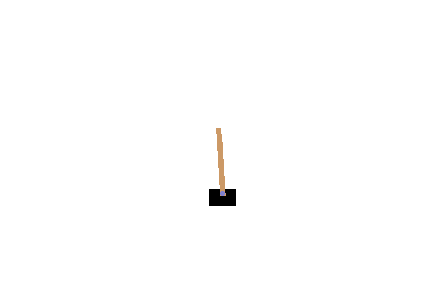
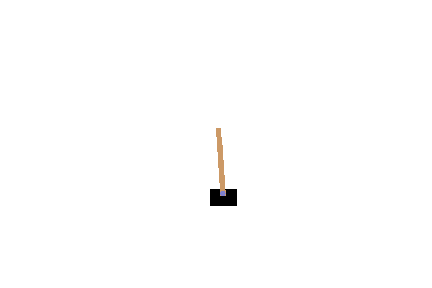
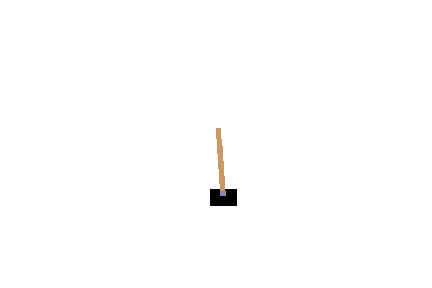
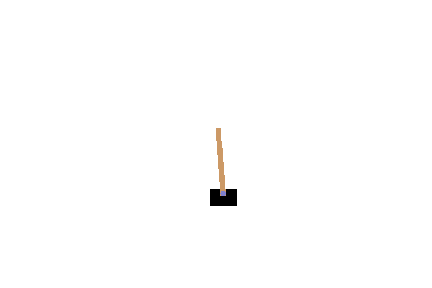
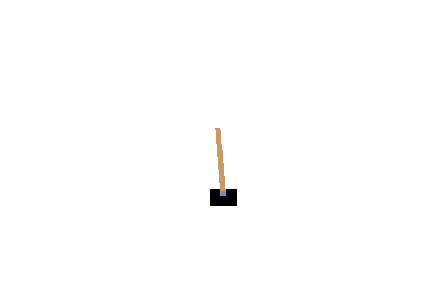
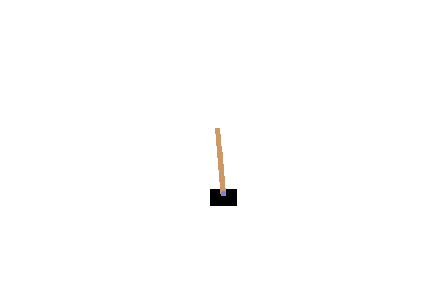
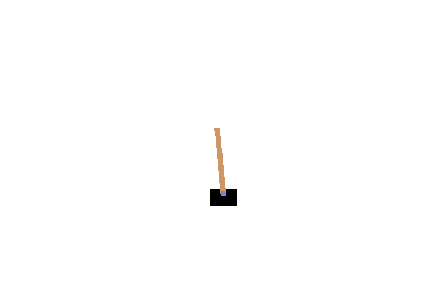
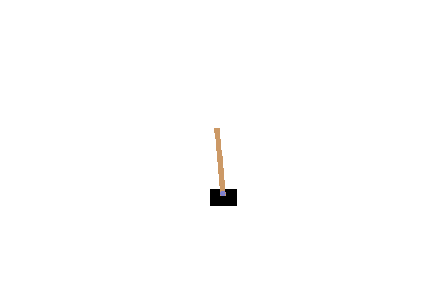
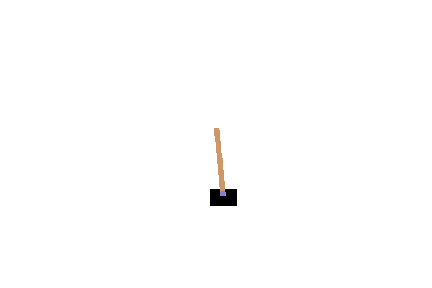
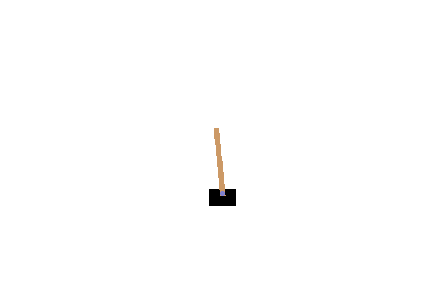
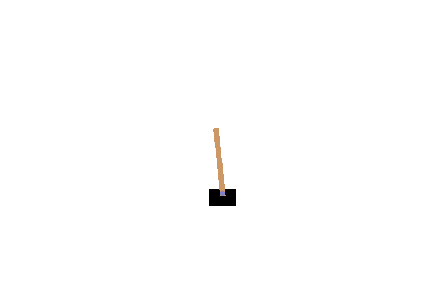
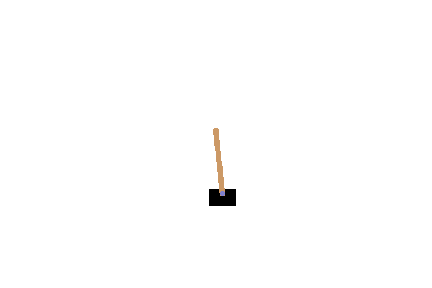
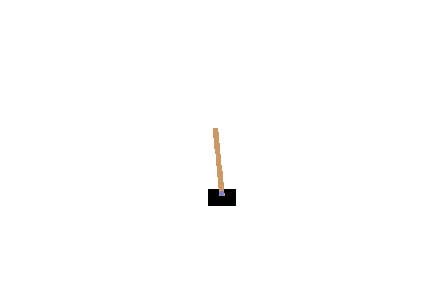
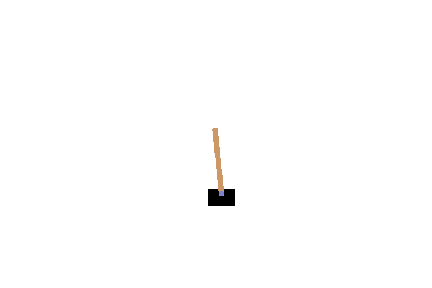
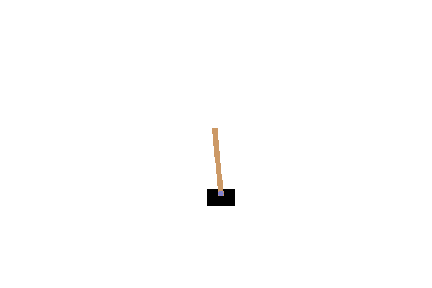
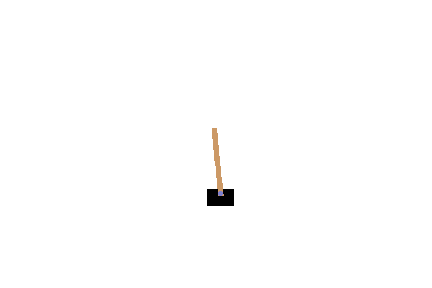
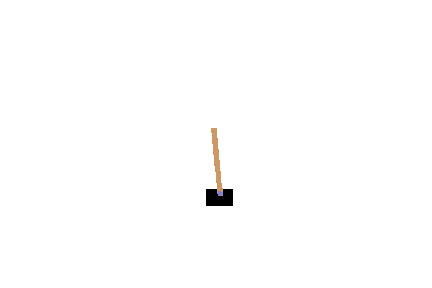
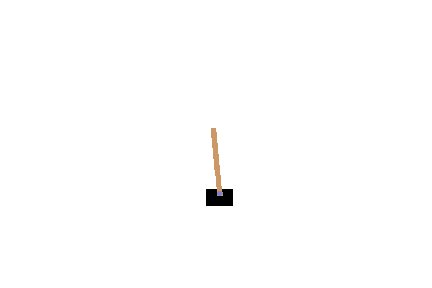
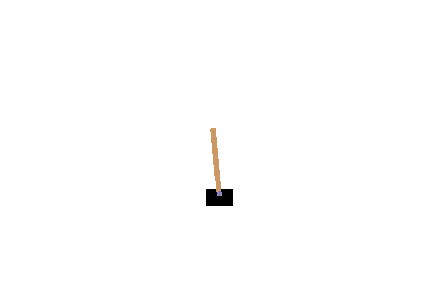
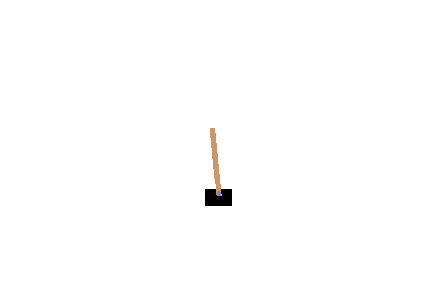
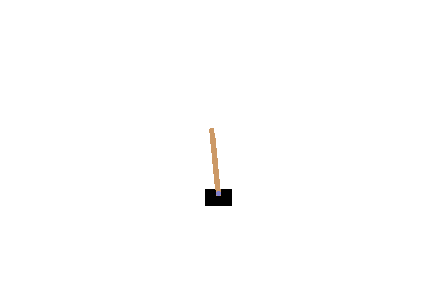
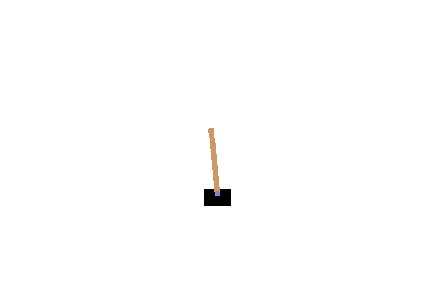
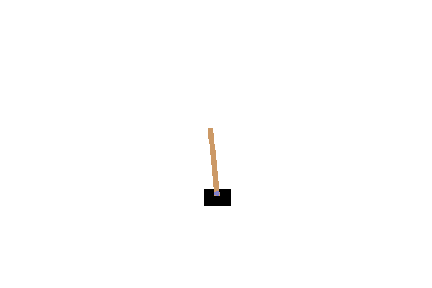
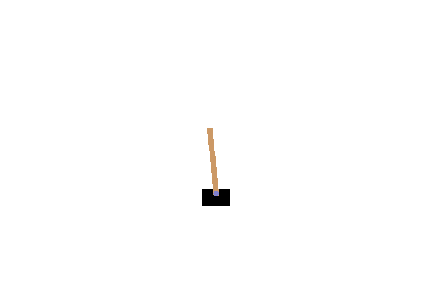
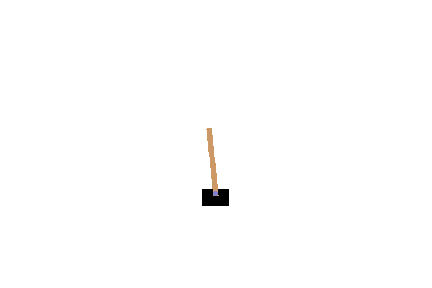
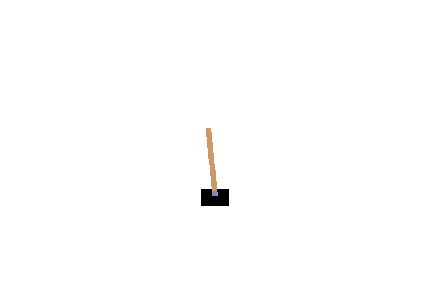
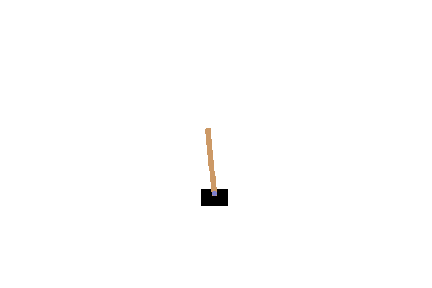
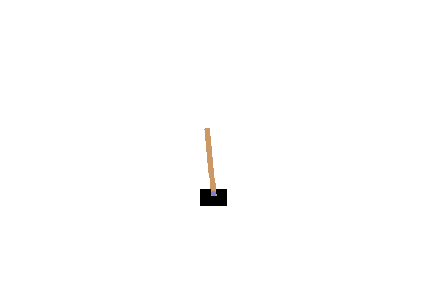
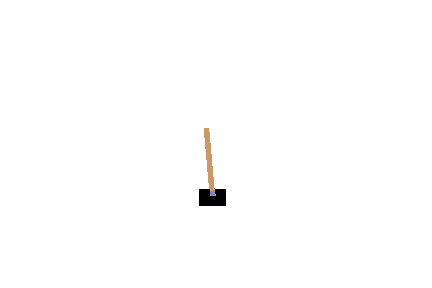
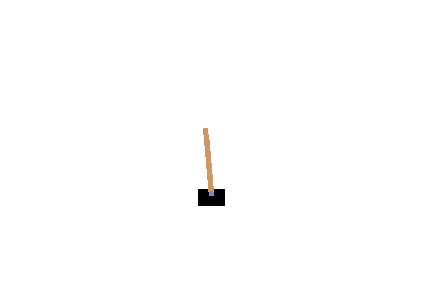
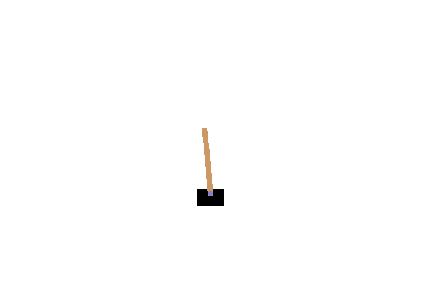
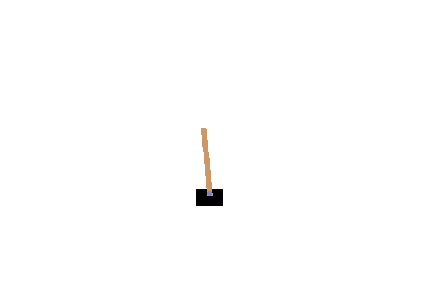
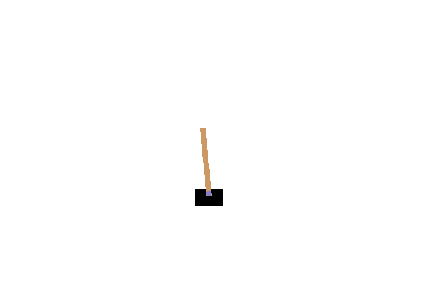
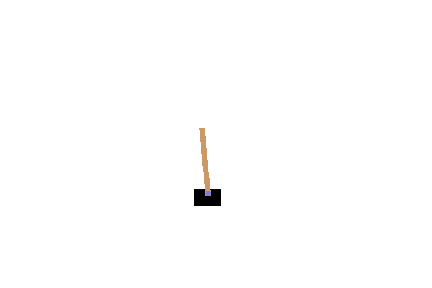
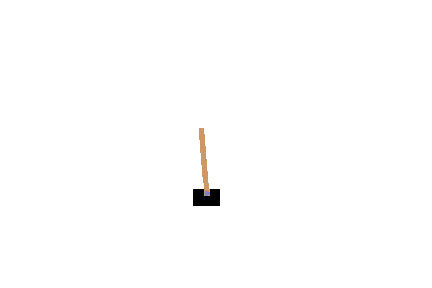
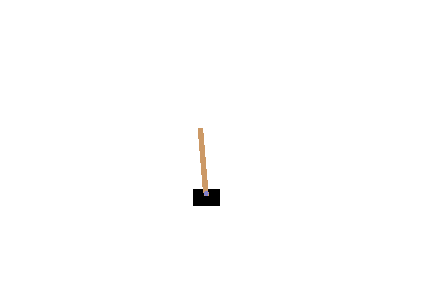
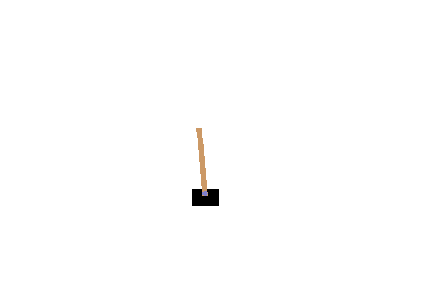
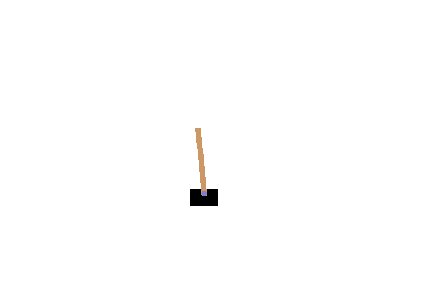
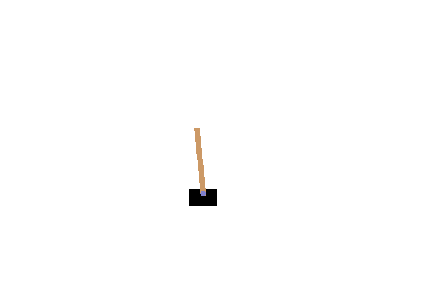
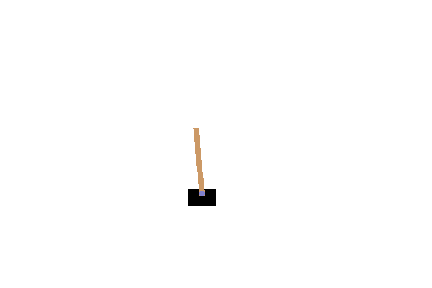
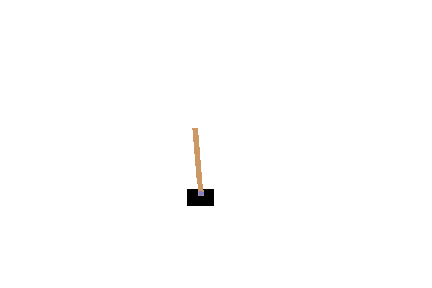
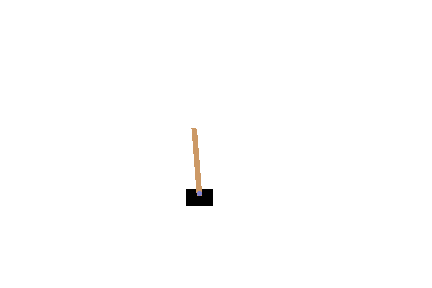
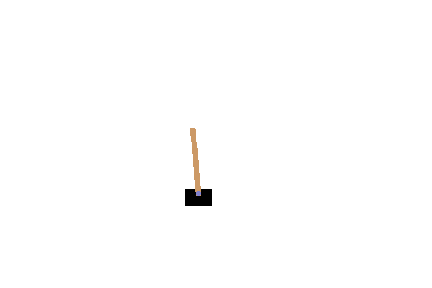
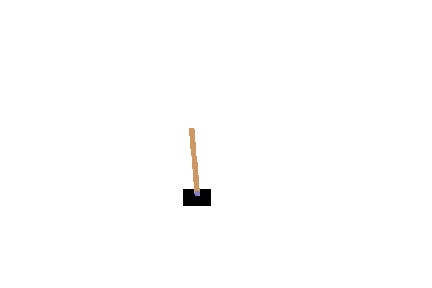
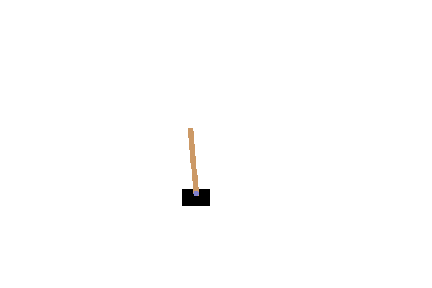
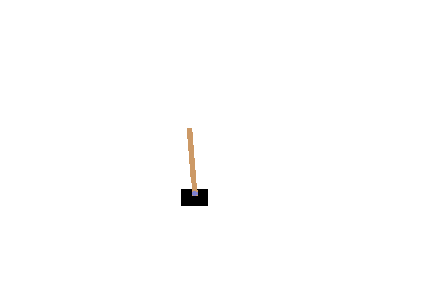
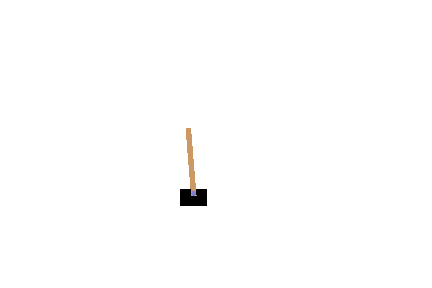
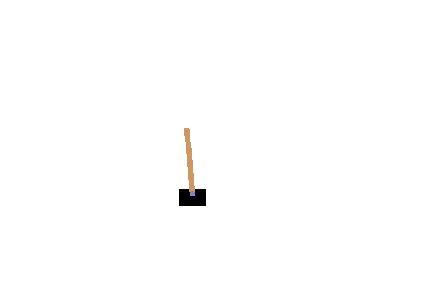
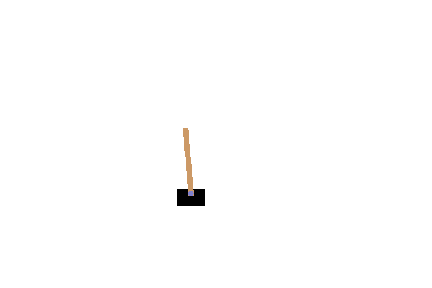
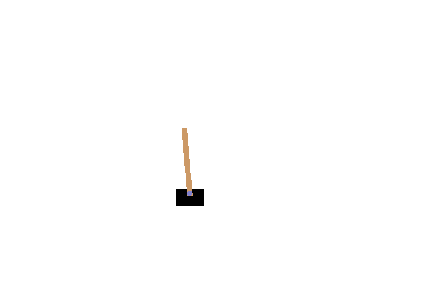
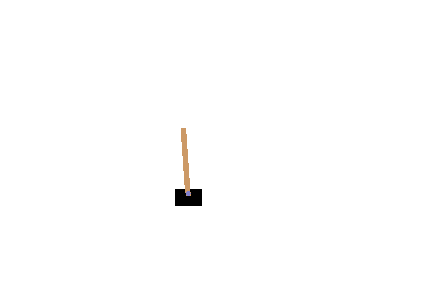
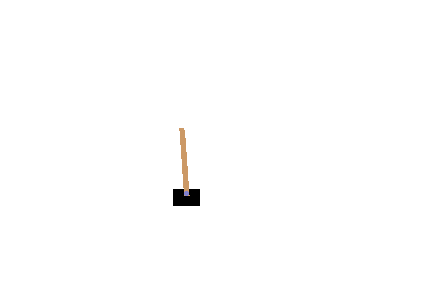
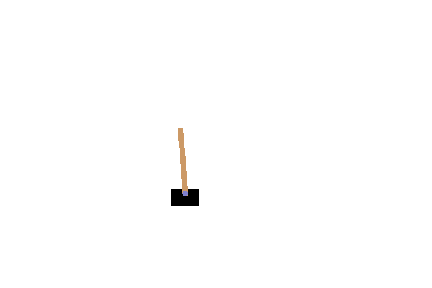
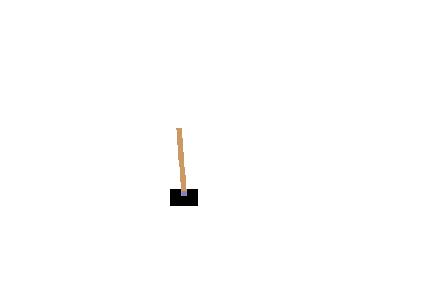
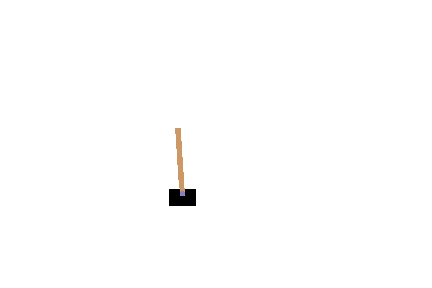
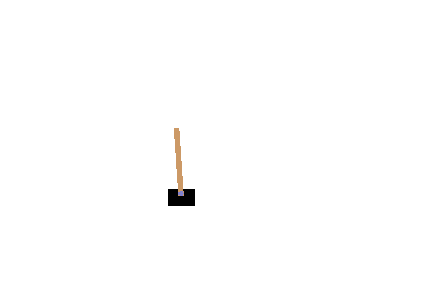
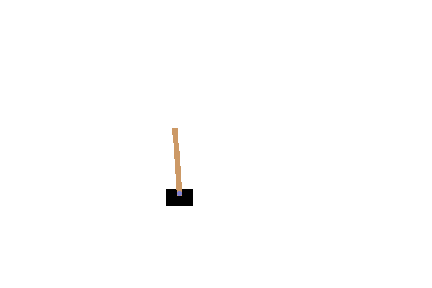
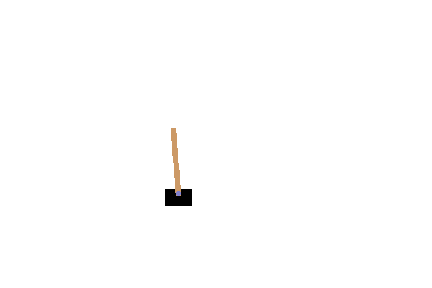
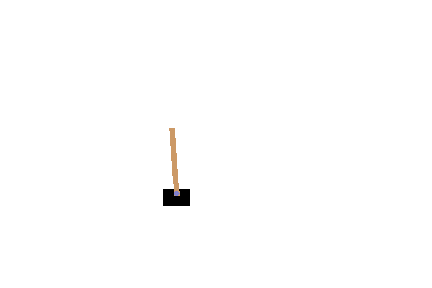
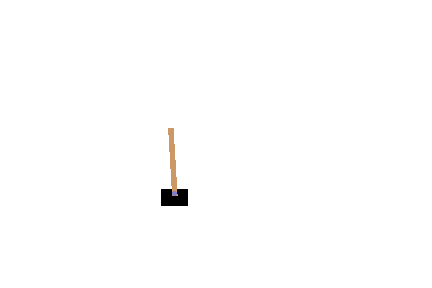
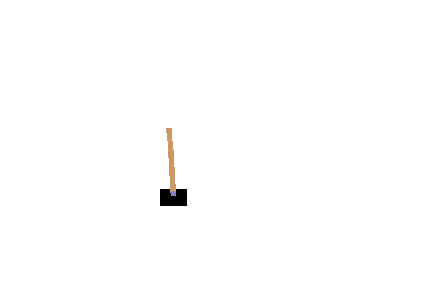
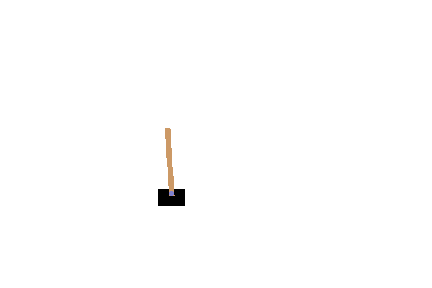
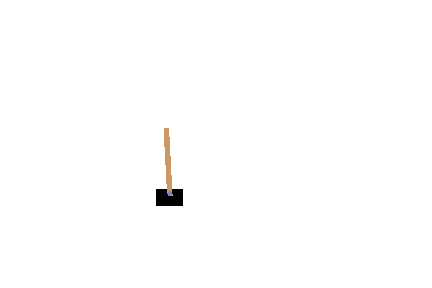
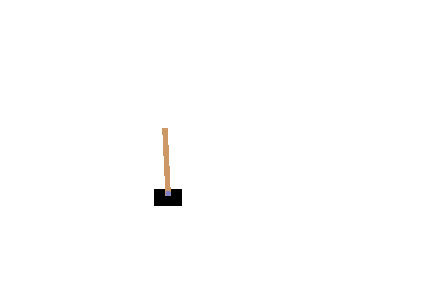
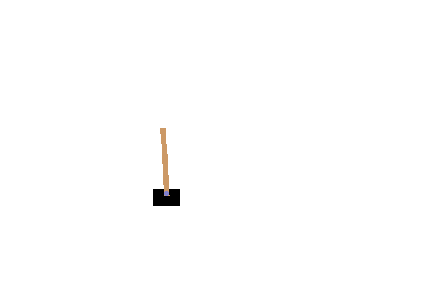
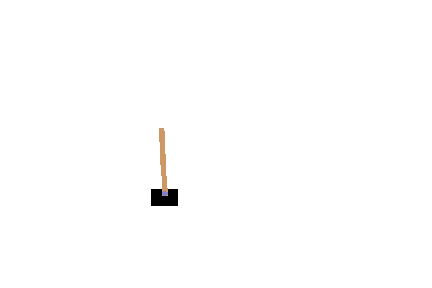
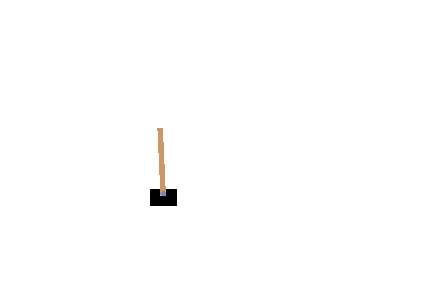
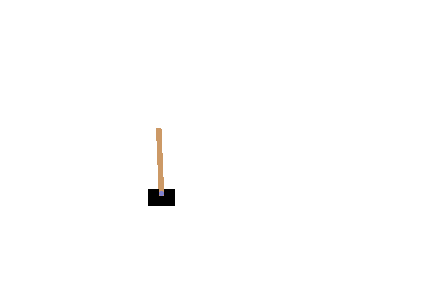
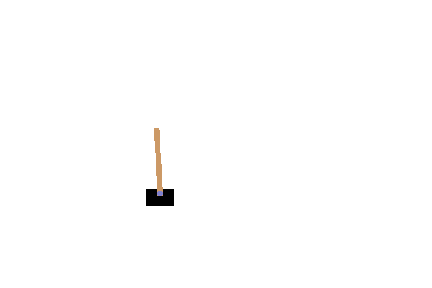
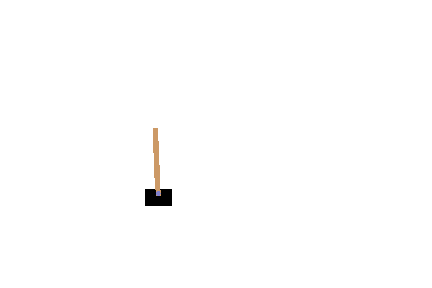
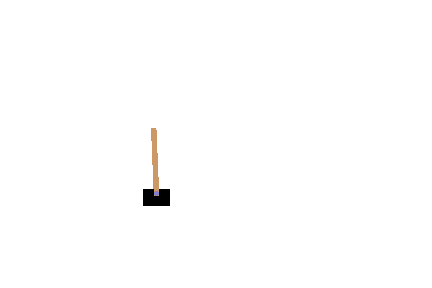
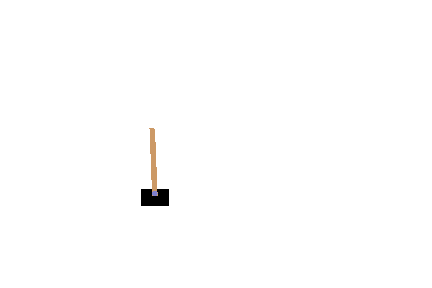
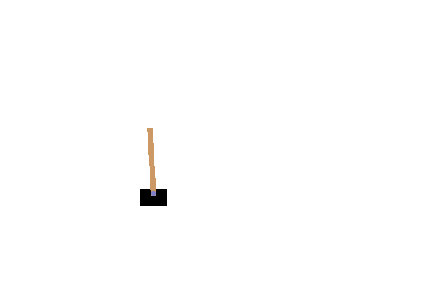
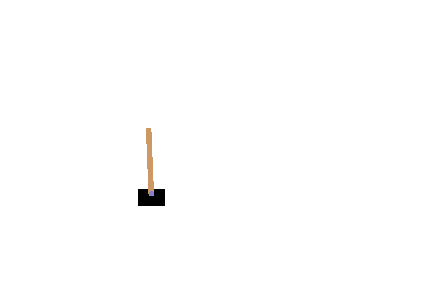
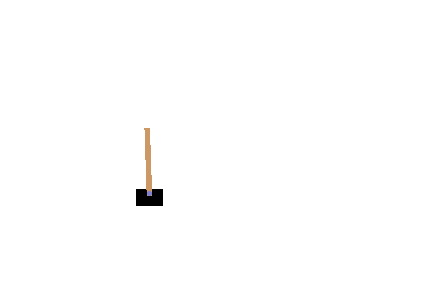
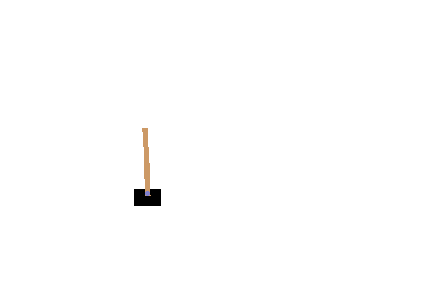
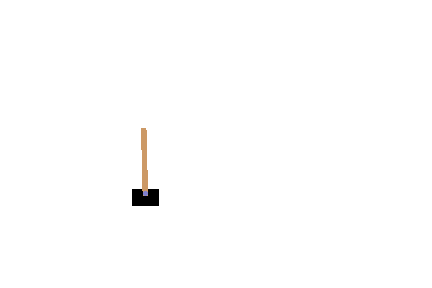
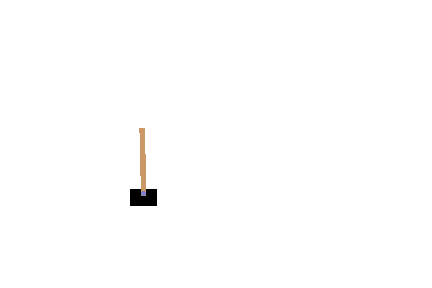
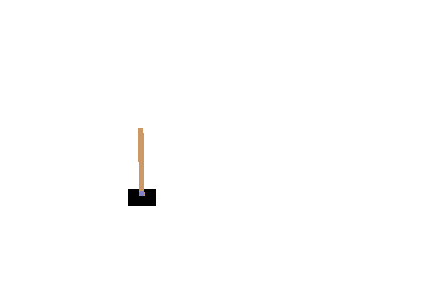
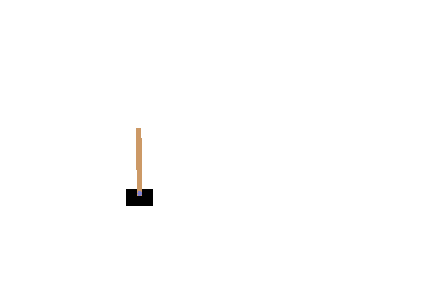
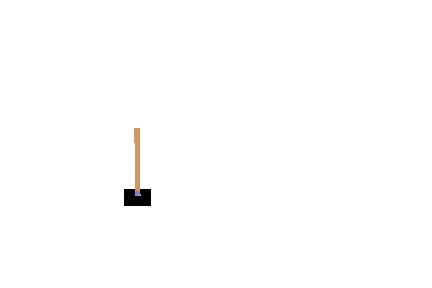
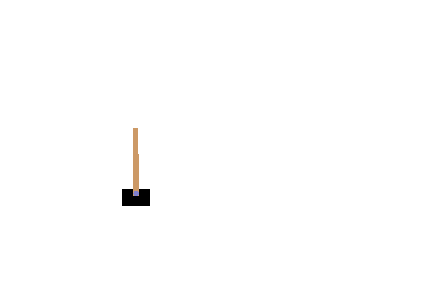
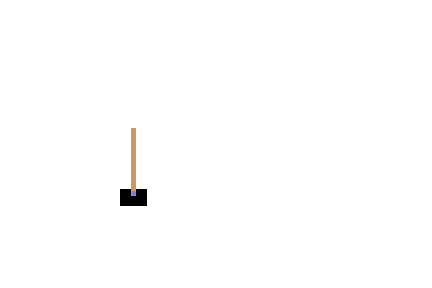
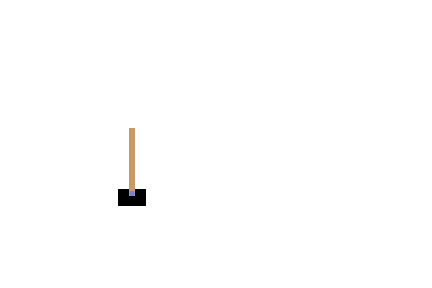
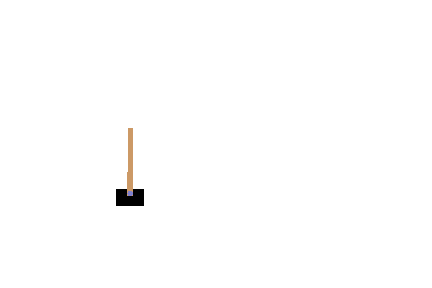
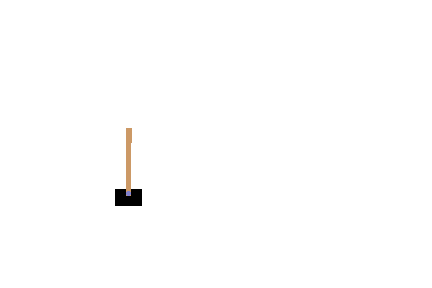
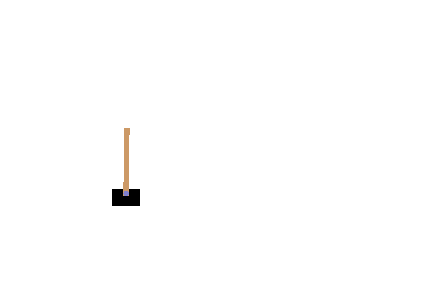
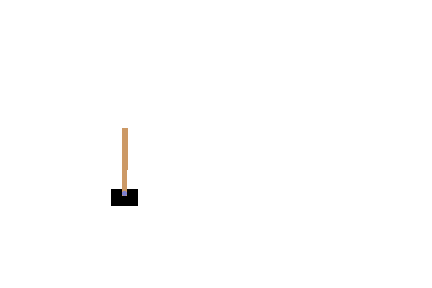
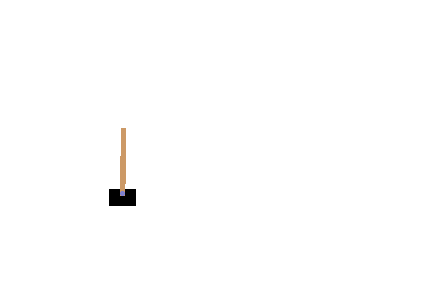
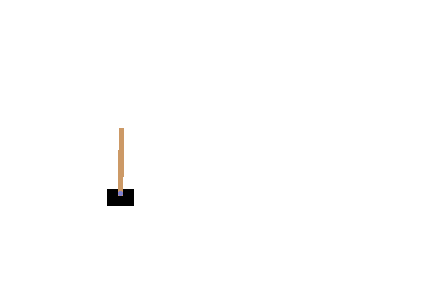
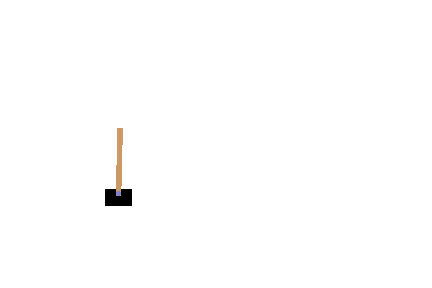
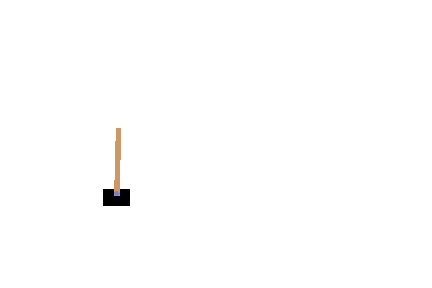
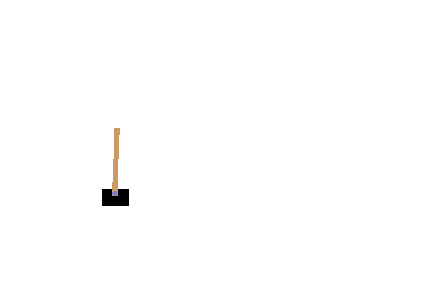
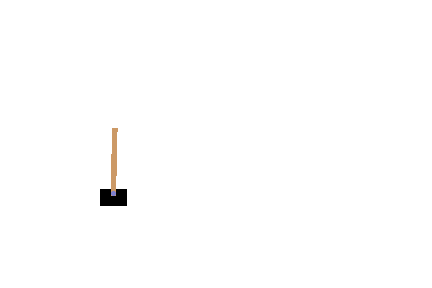
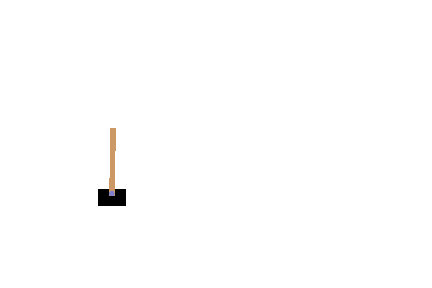
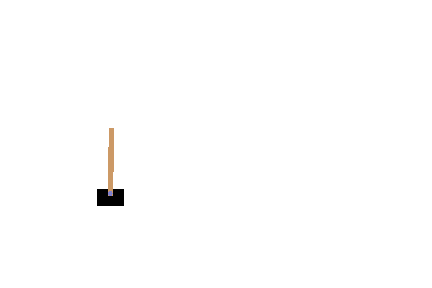
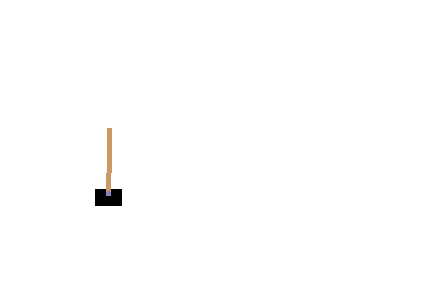
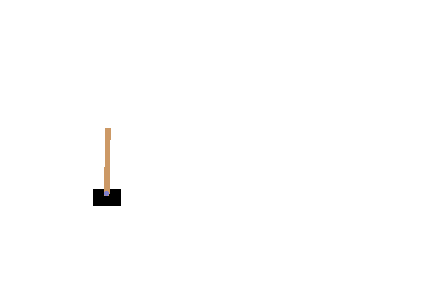
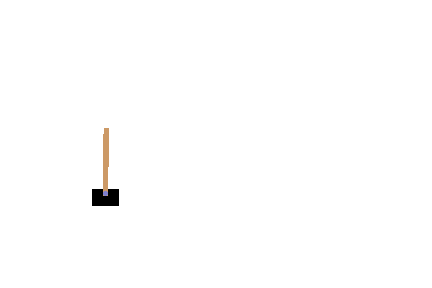
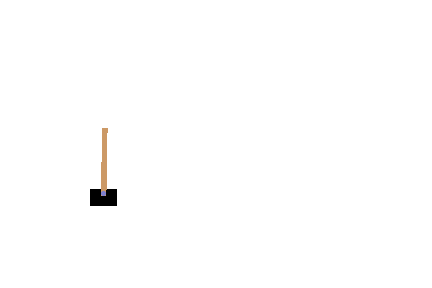
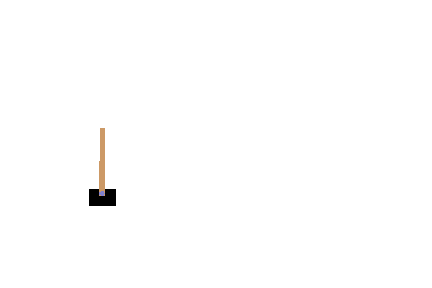
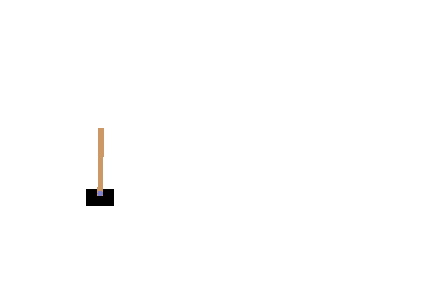
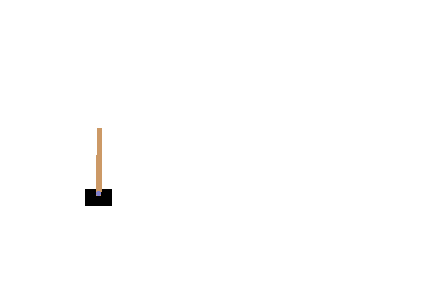
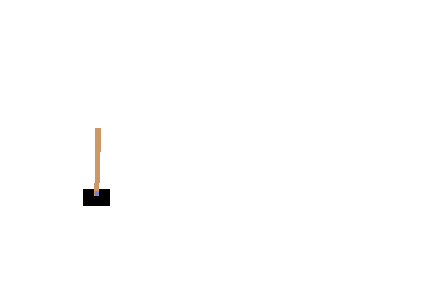
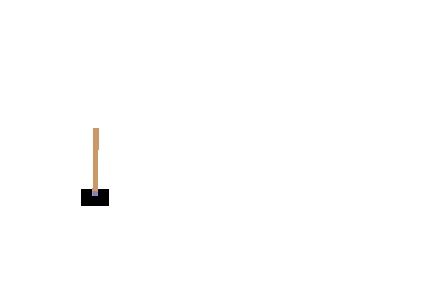
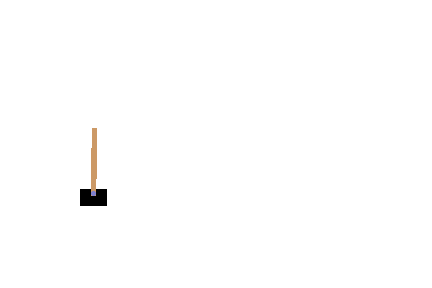
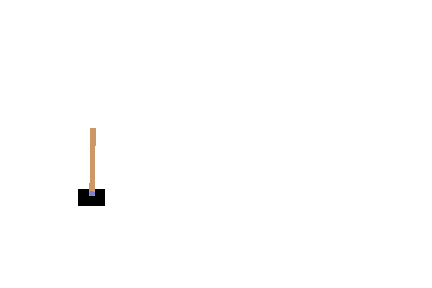
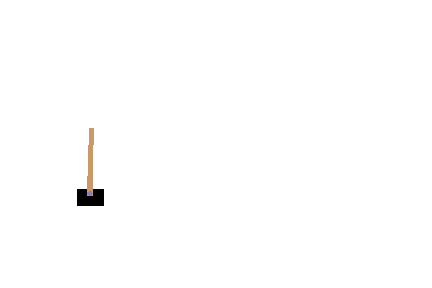
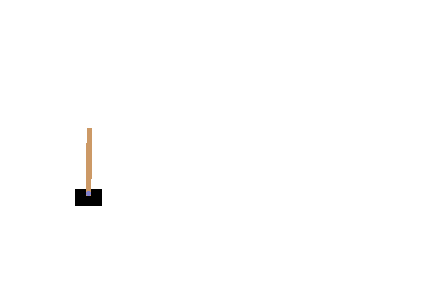
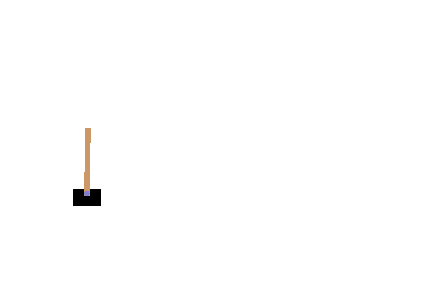
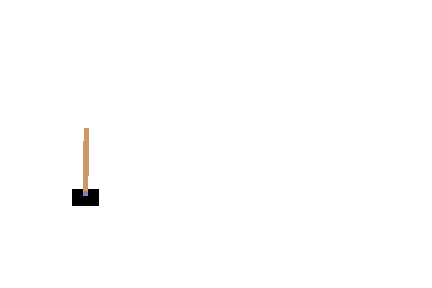
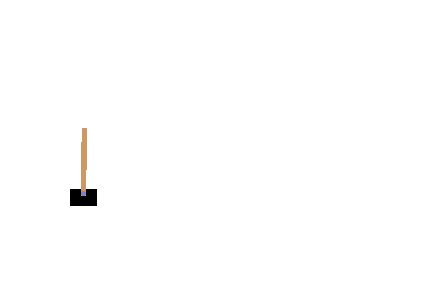
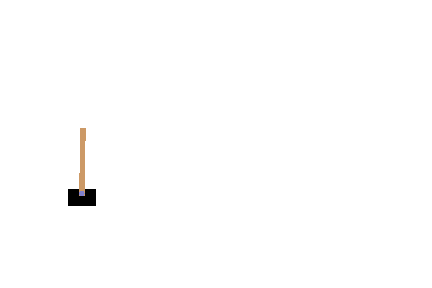
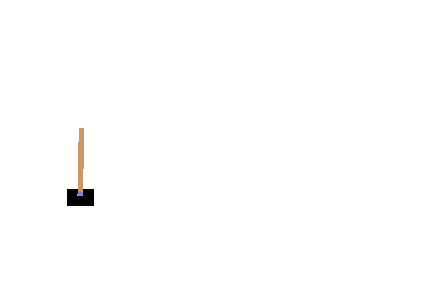
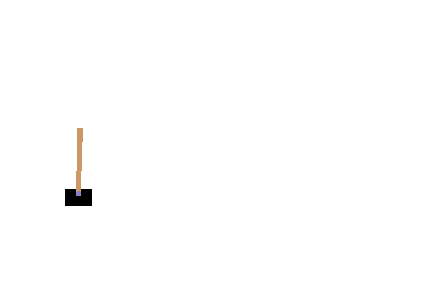
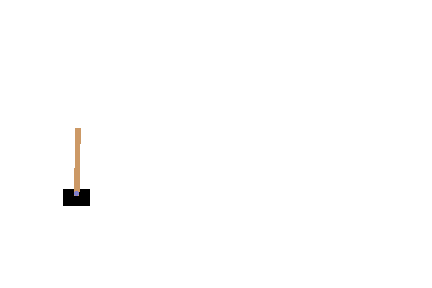
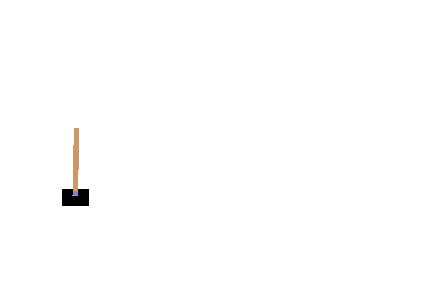
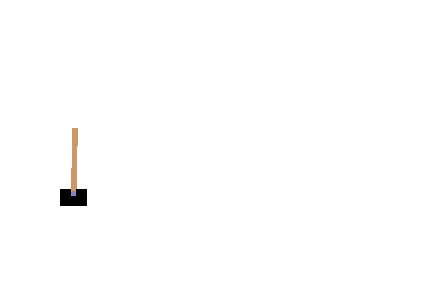
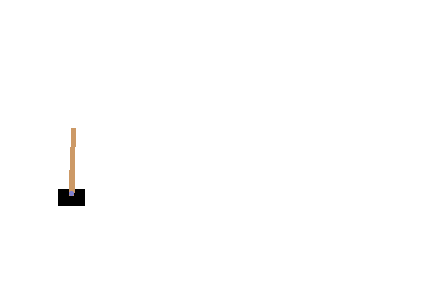
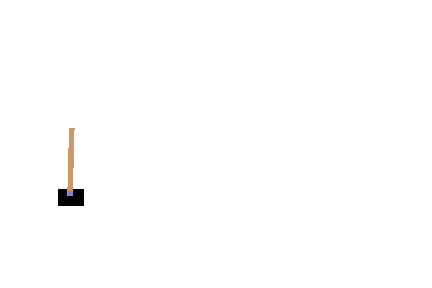
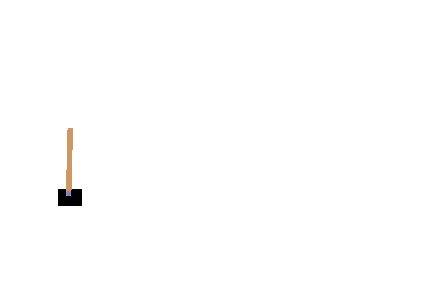
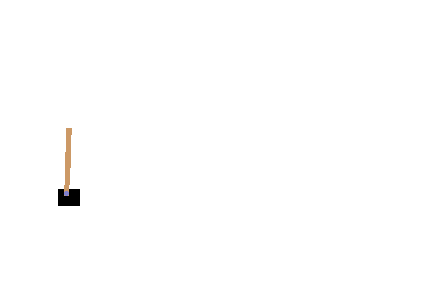
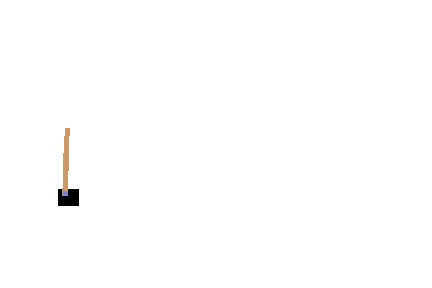
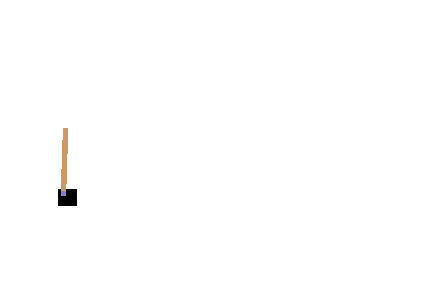
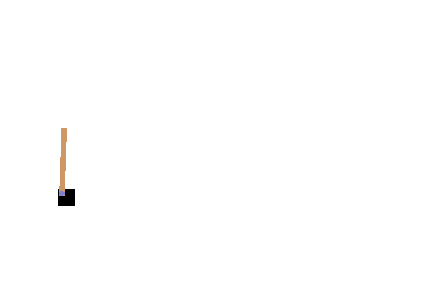
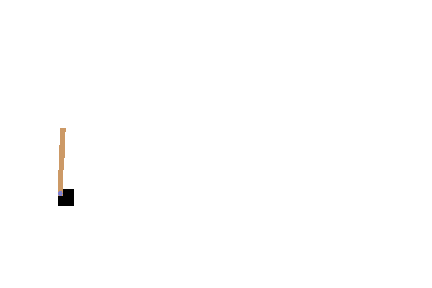
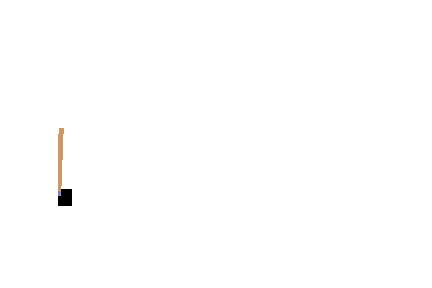

In [7]:
e.test(d)

## DQN Torch

In [20]:
d = DQNTorch(learning_rate=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

Model Created!


Epsilon : 3.7074446659261245e-44, Num Steps : 199, Avg Reward with Window Size 25 : 67.52: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it]         
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


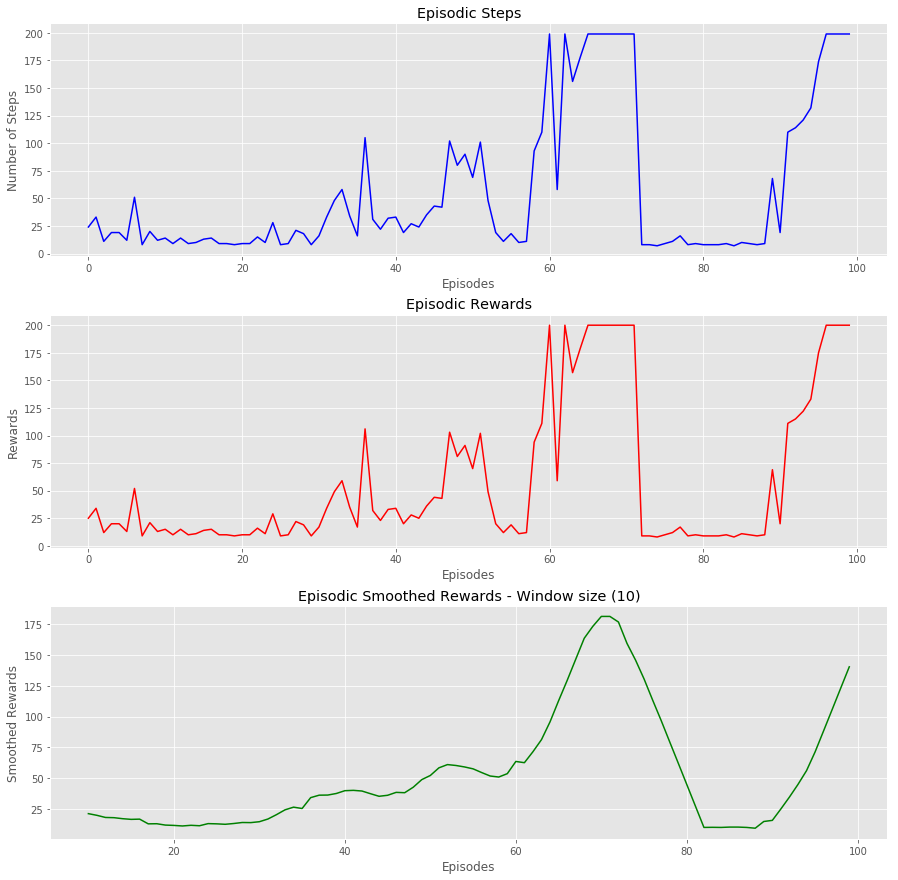

In [21]:
e = Env_Wrapper(env)
stats = e.train(d,episodes=100,train_episodal=False)

Total reward for episode 0: 200.0



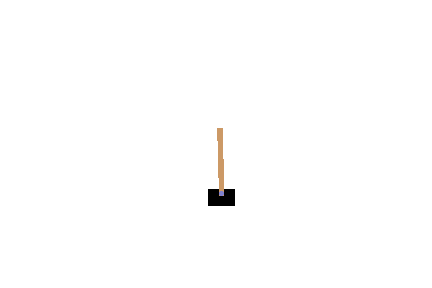
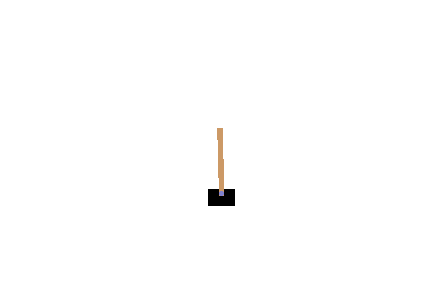
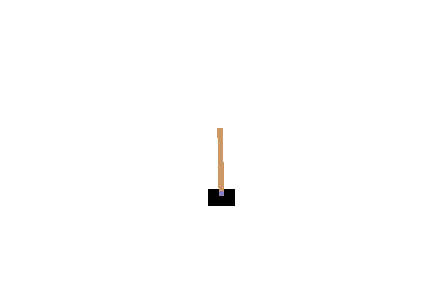
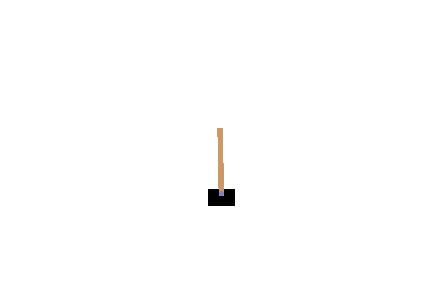
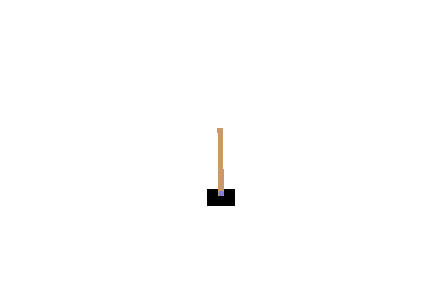
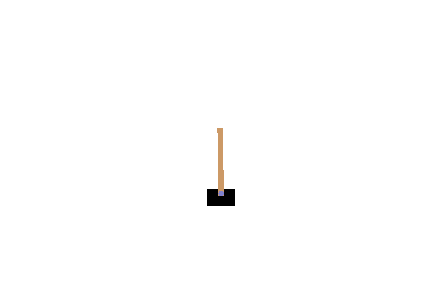
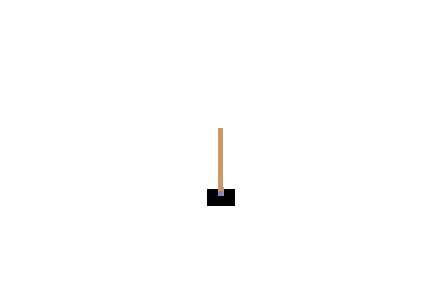
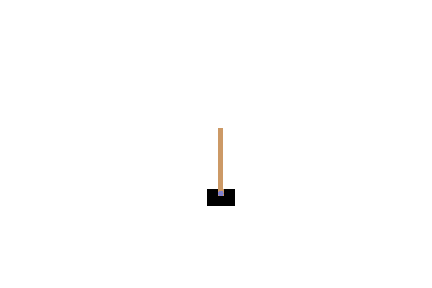
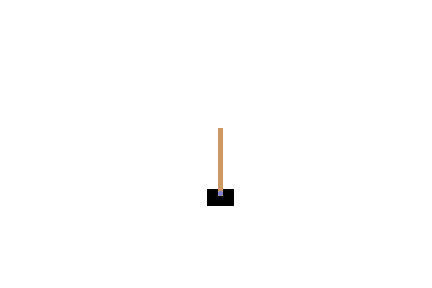
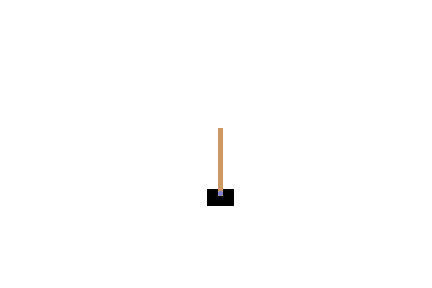
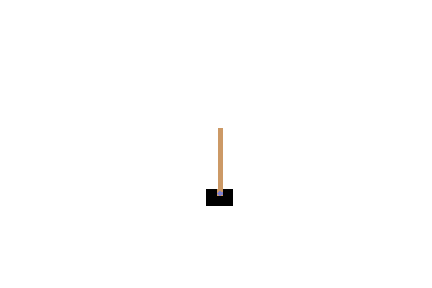
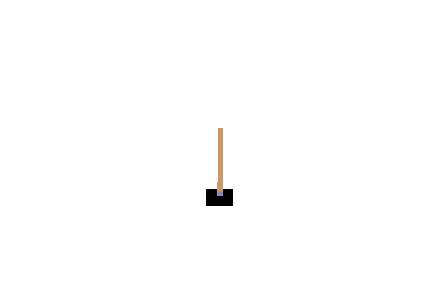
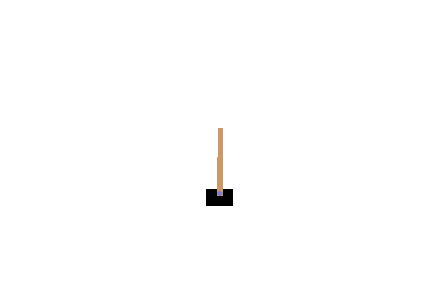
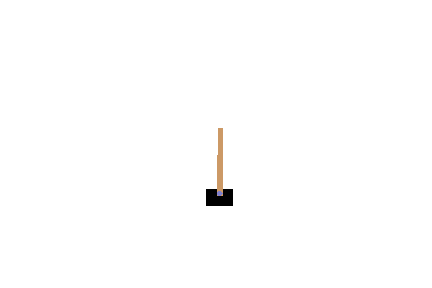
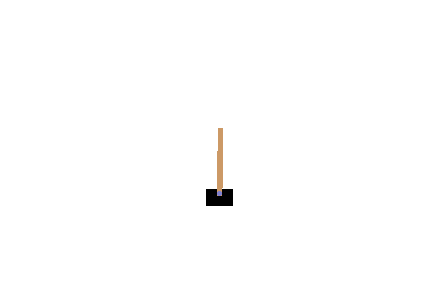
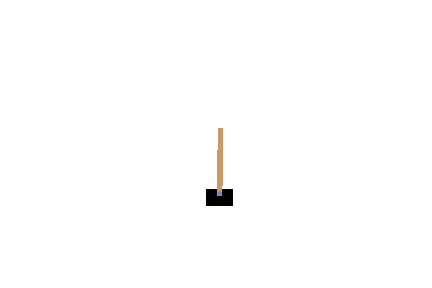
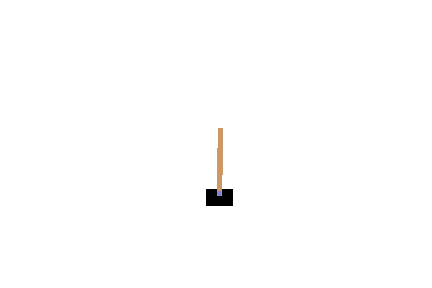
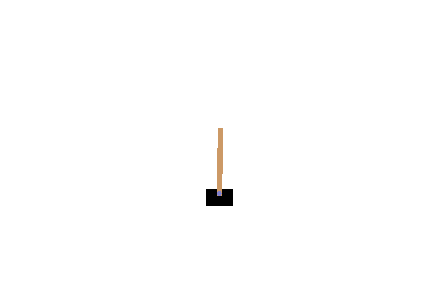
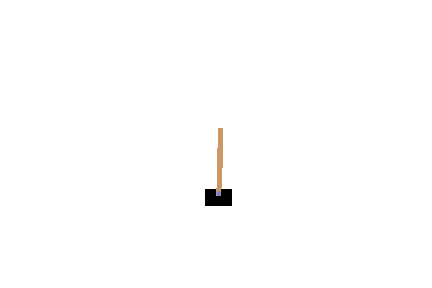
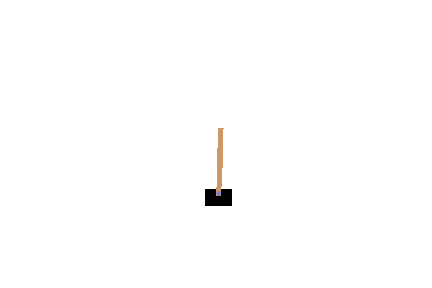
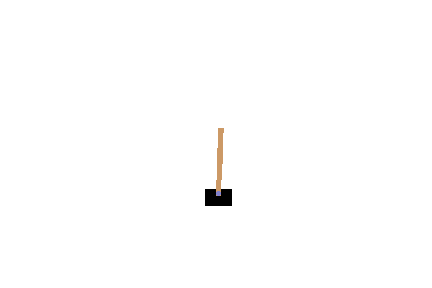
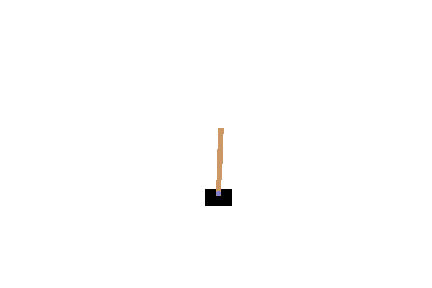
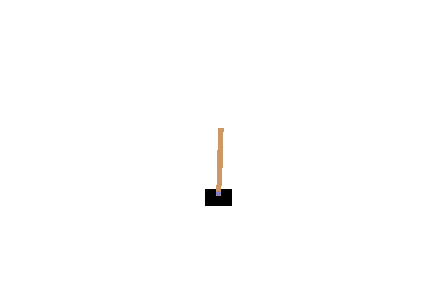
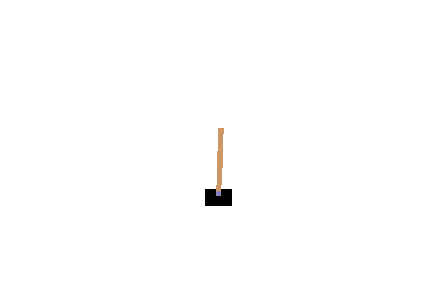
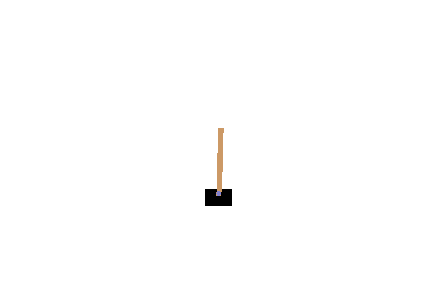
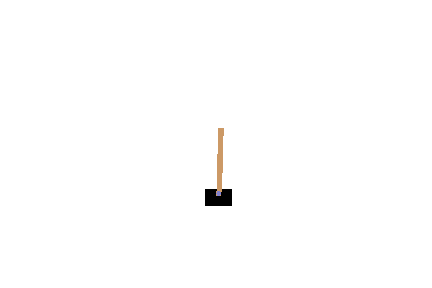
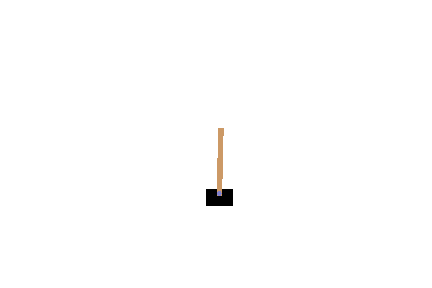
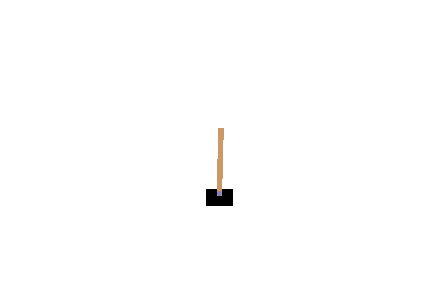
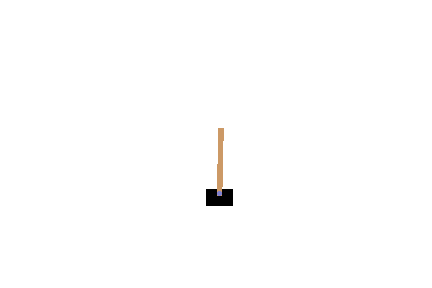
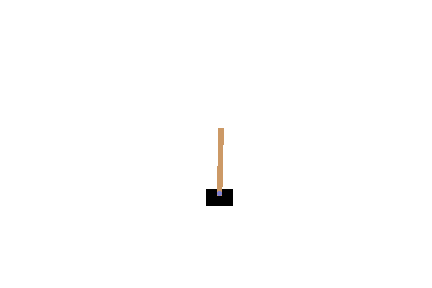
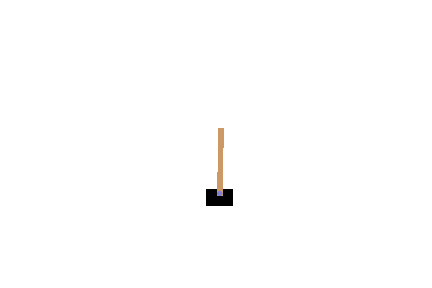
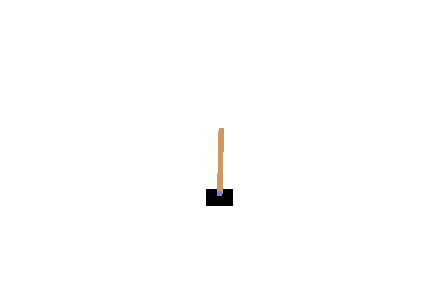
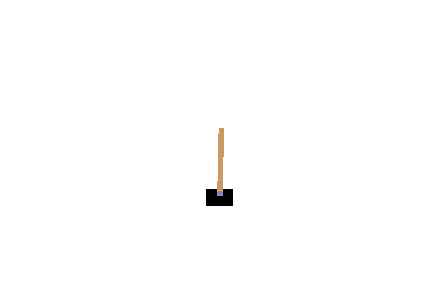
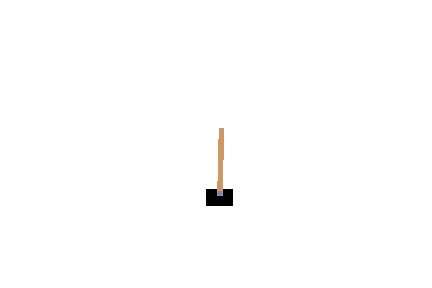
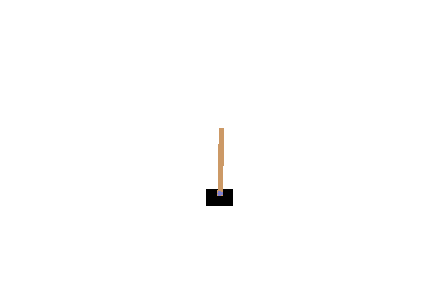
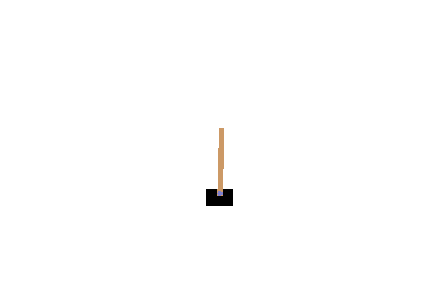
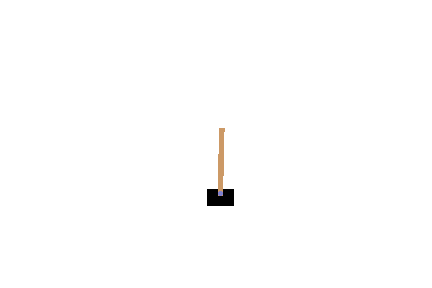
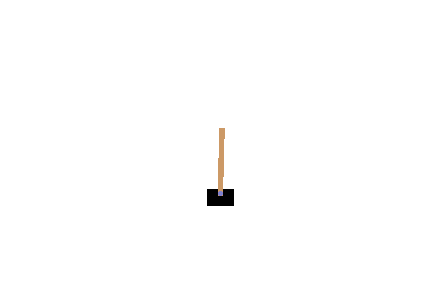
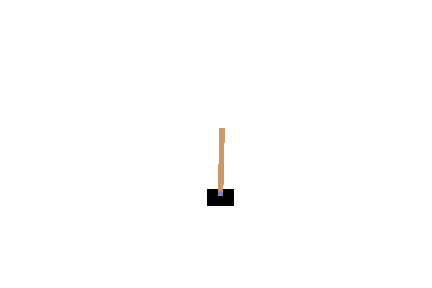
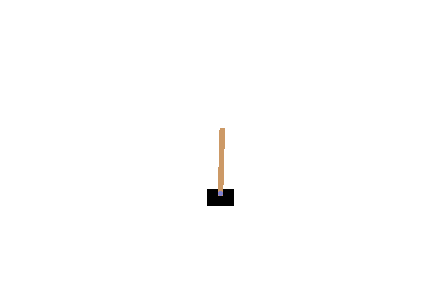
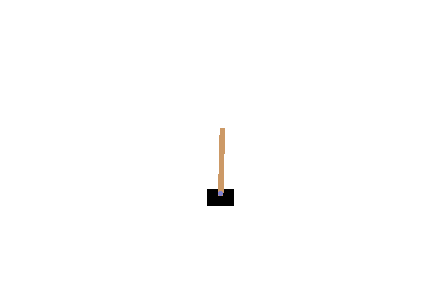
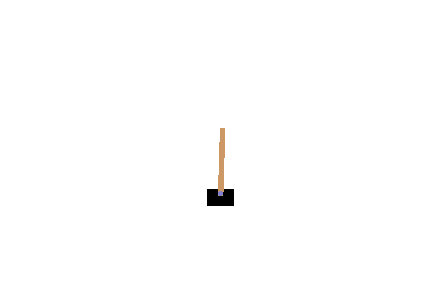
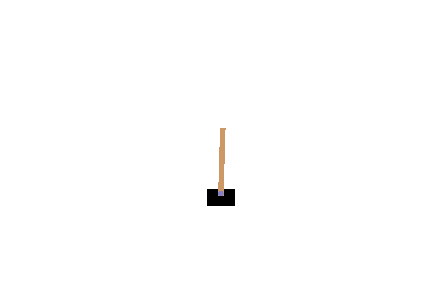
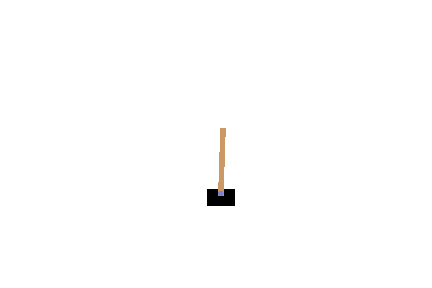
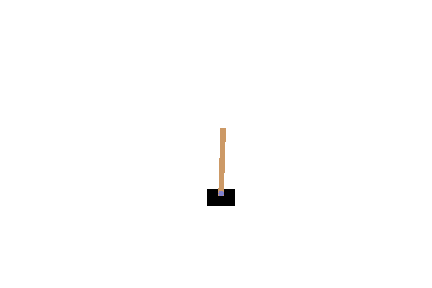
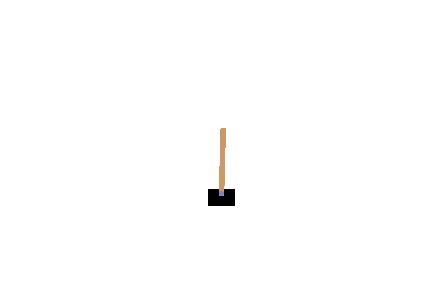
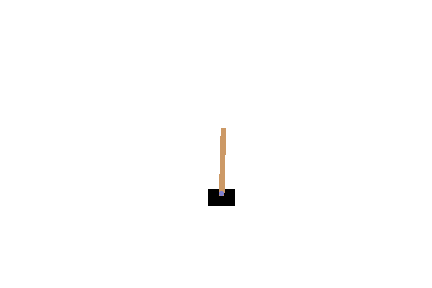
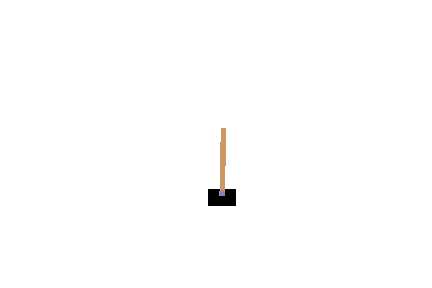
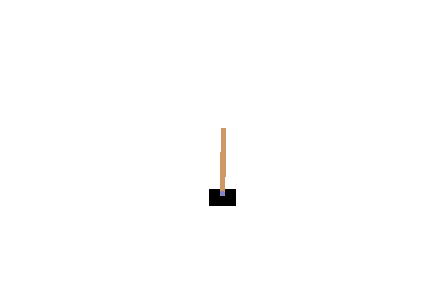
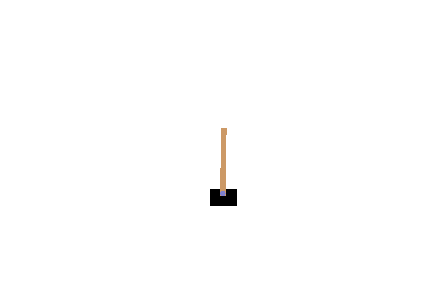
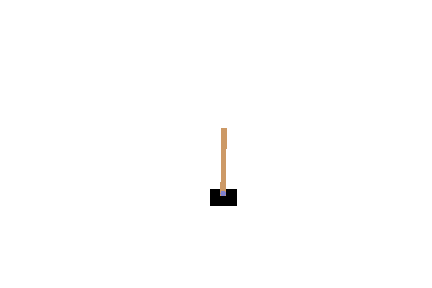
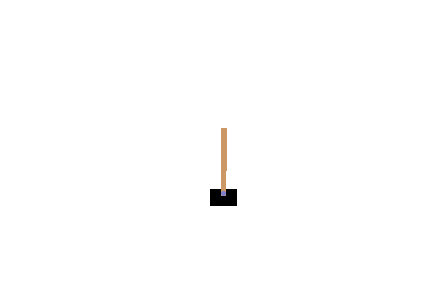
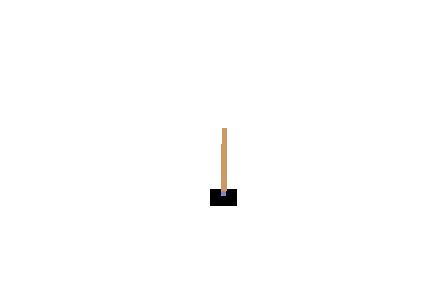
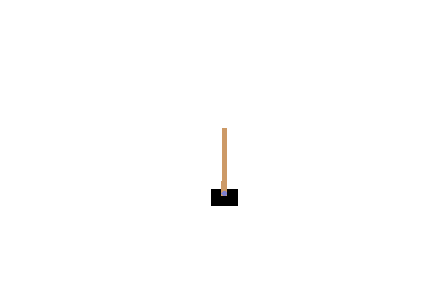
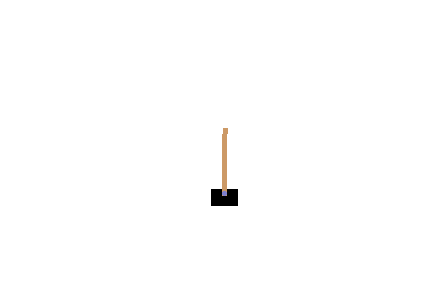
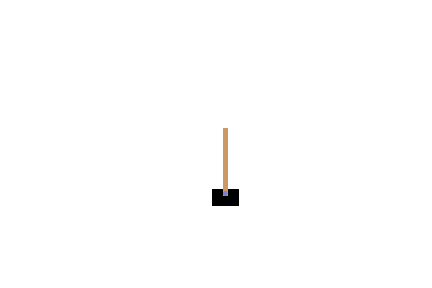
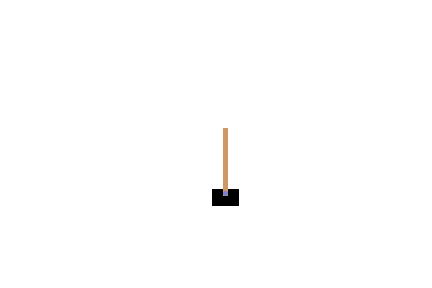
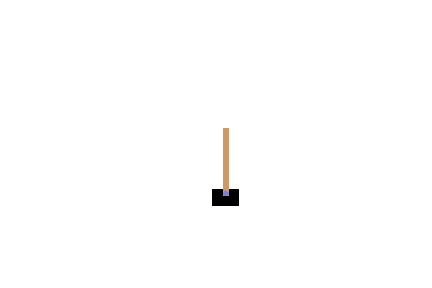
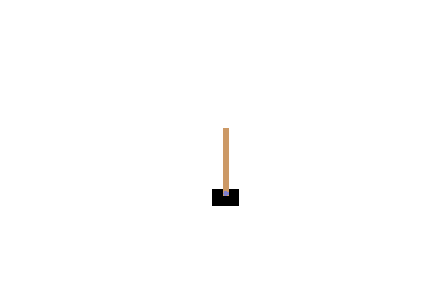
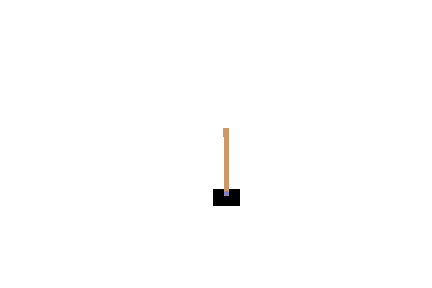
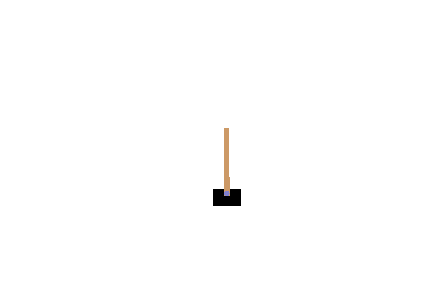
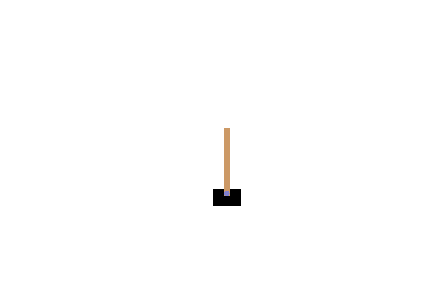
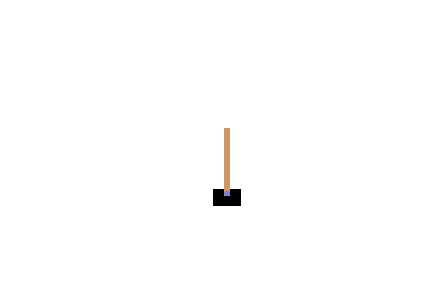
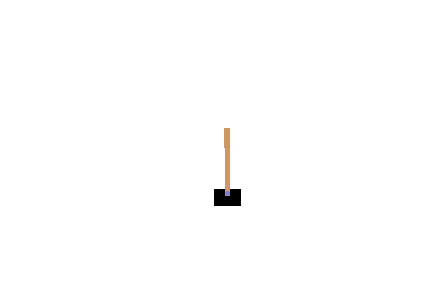
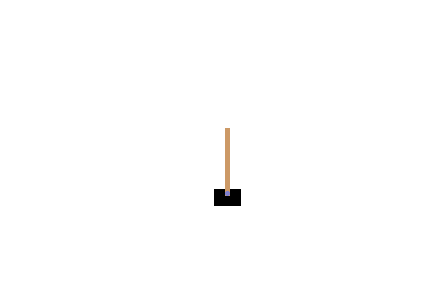
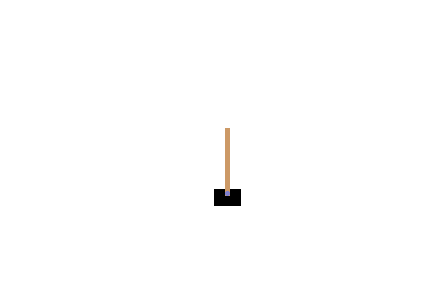
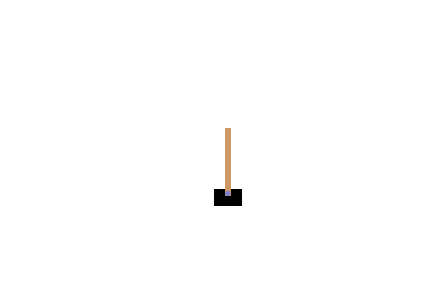
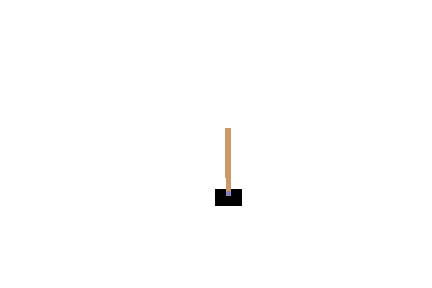
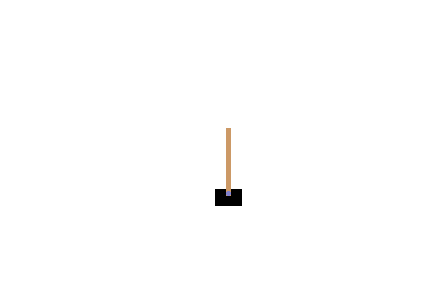
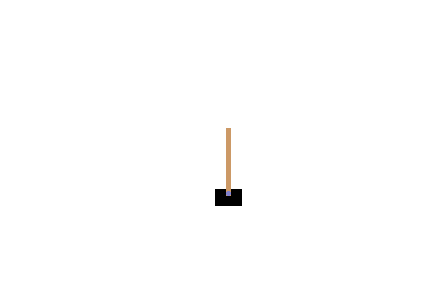
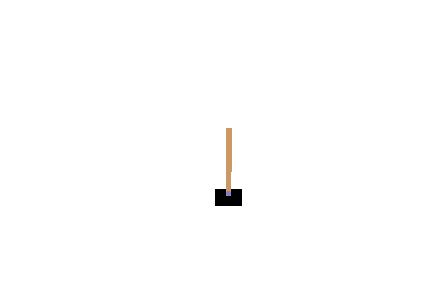
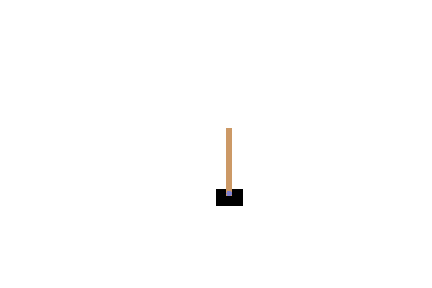
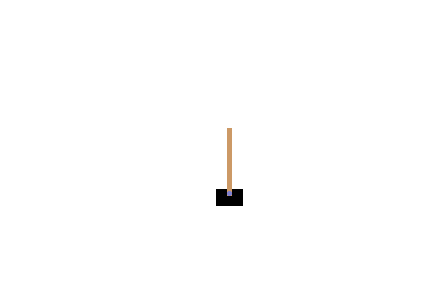
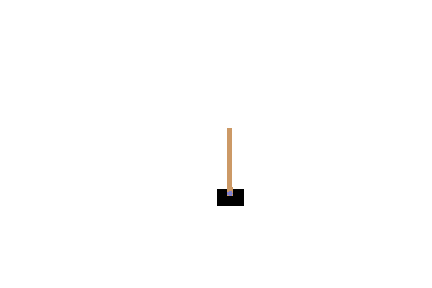
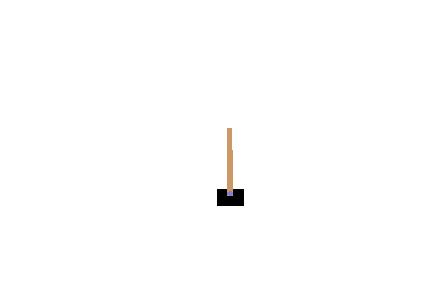
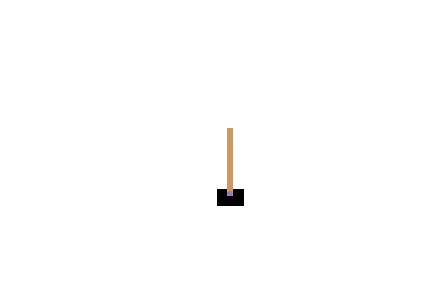
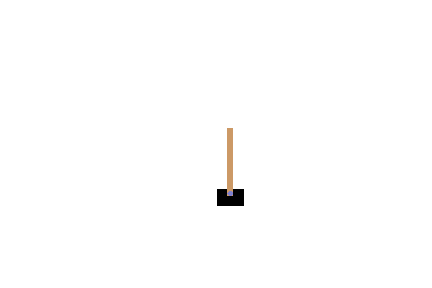
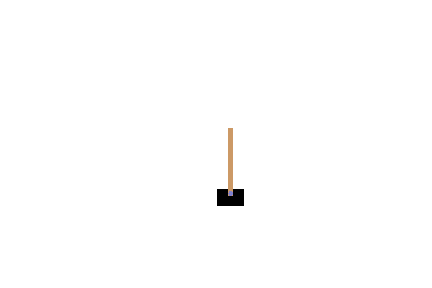
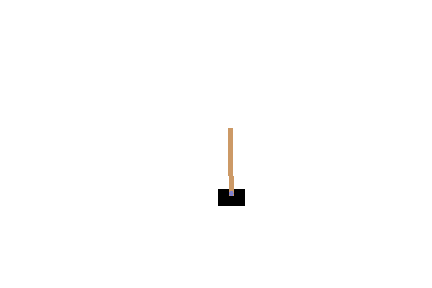
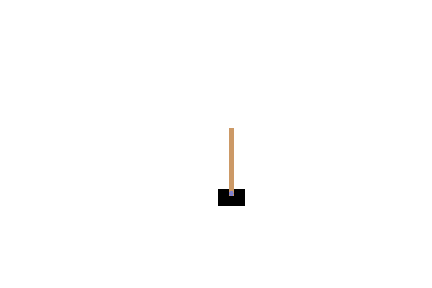
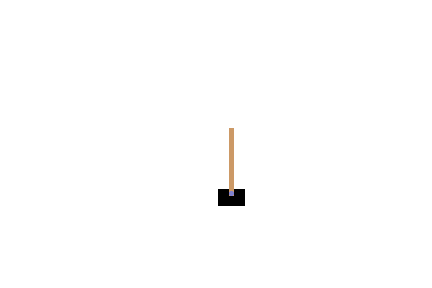
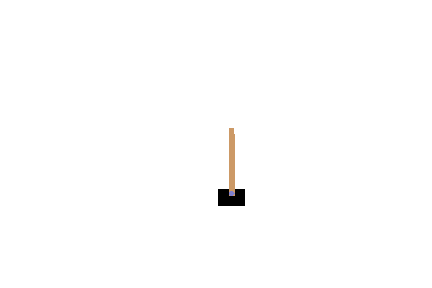
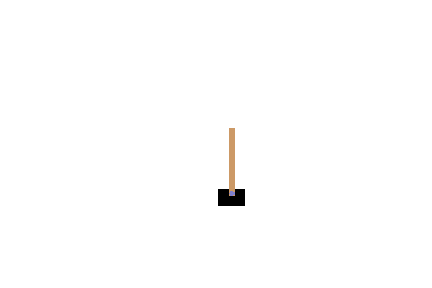
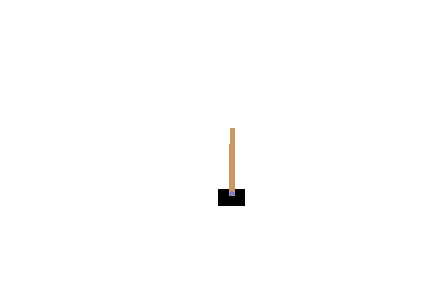
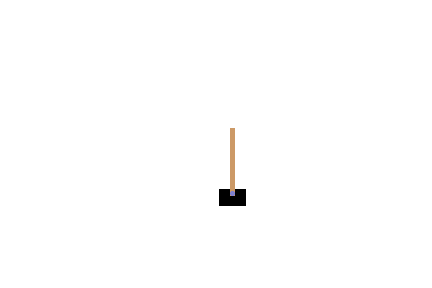
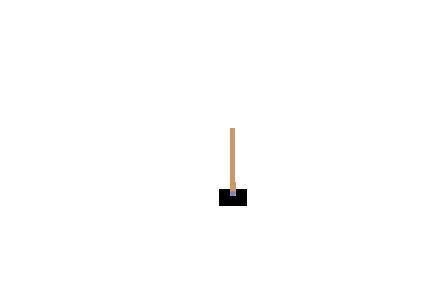
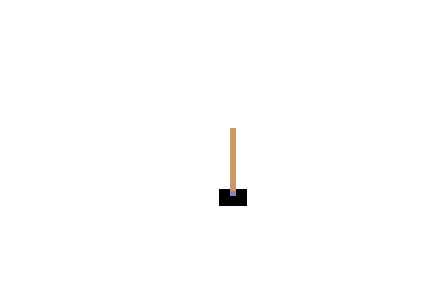
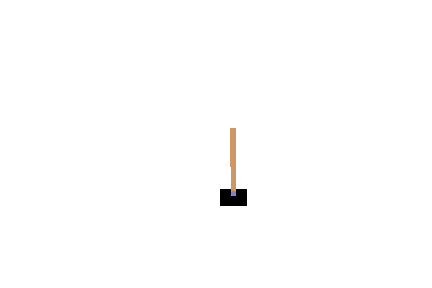
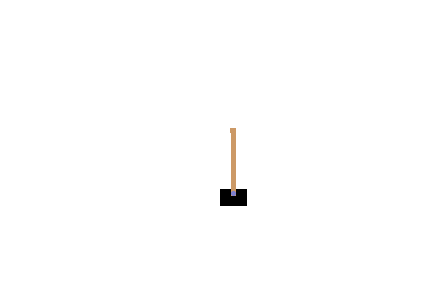
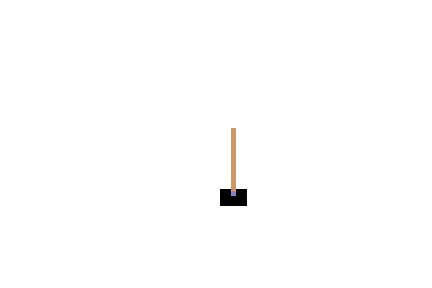
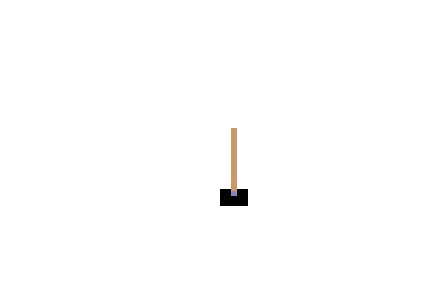
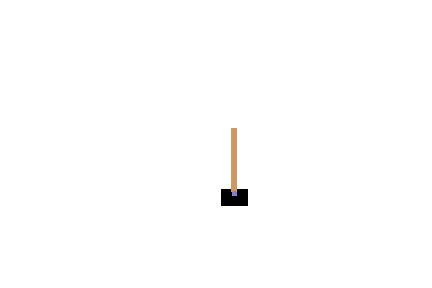
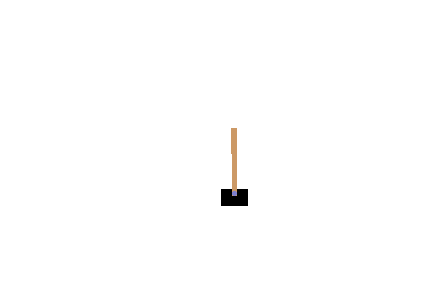
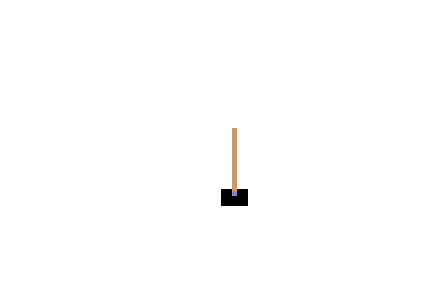
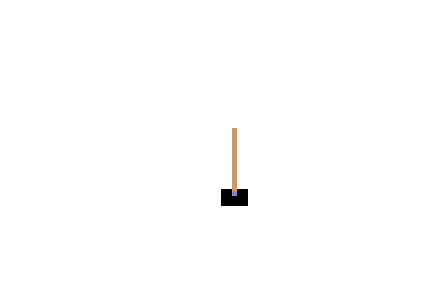
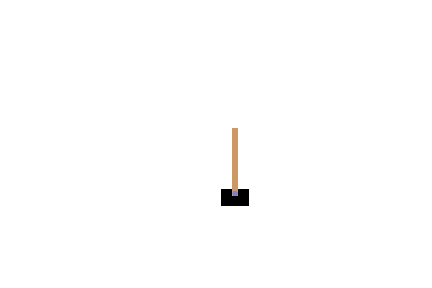
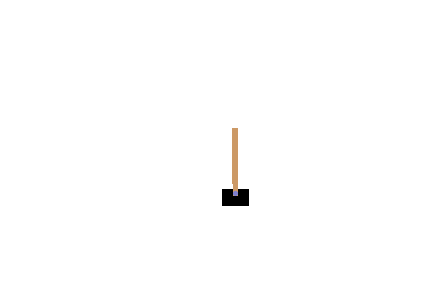
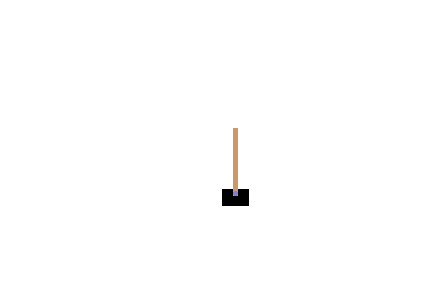
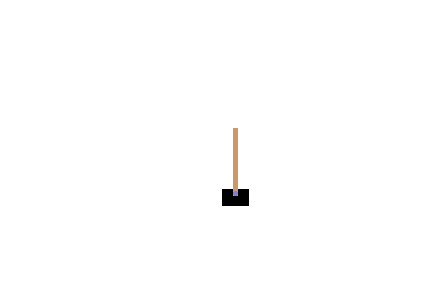
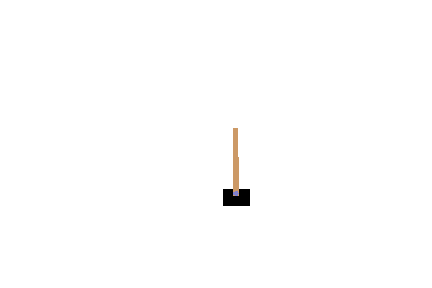
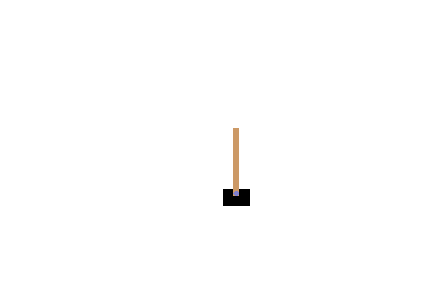
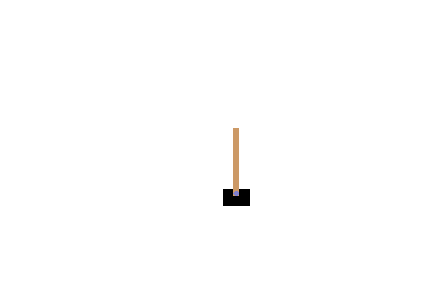
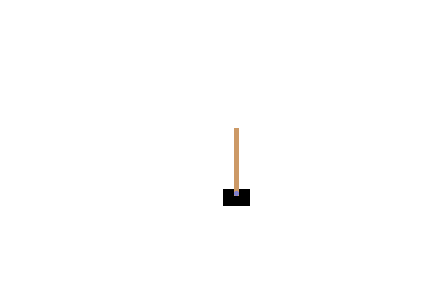
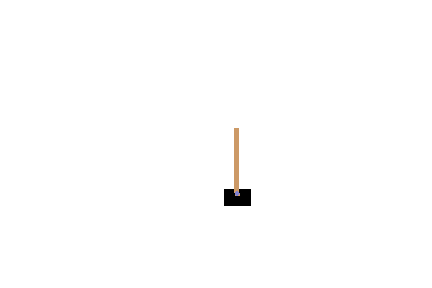
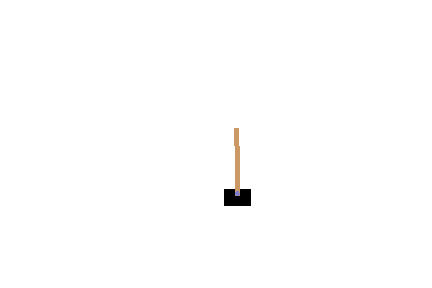
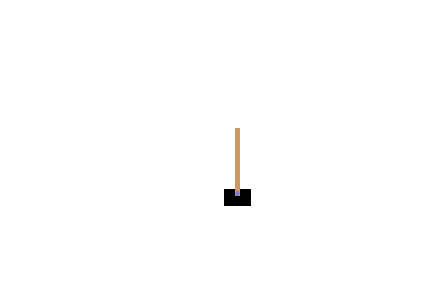
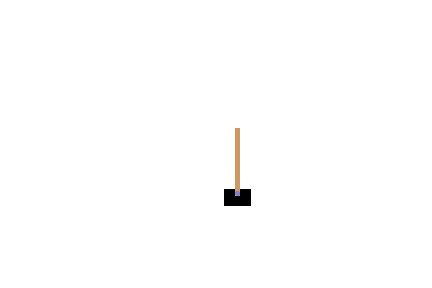
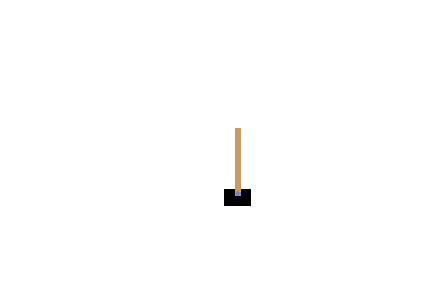
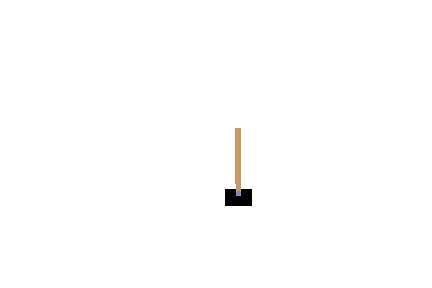
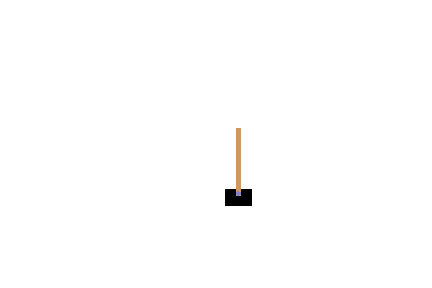
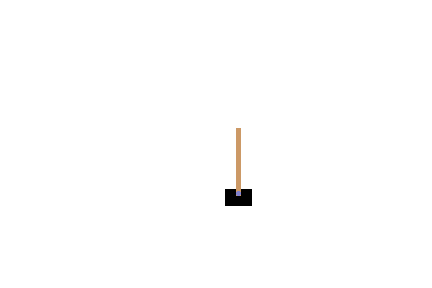
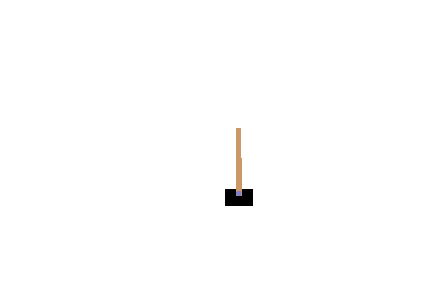
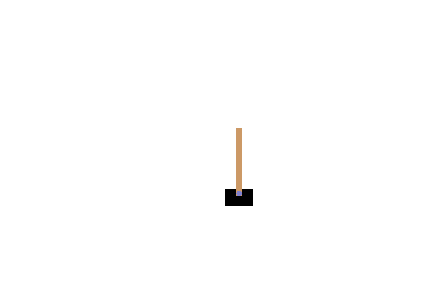
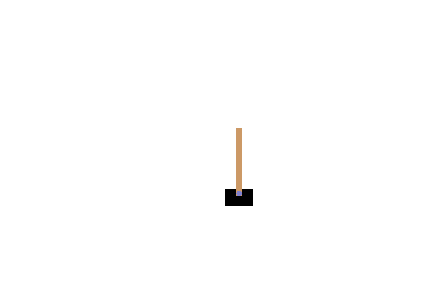
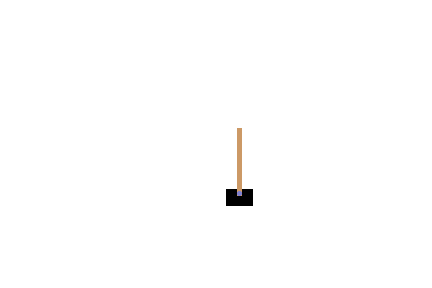
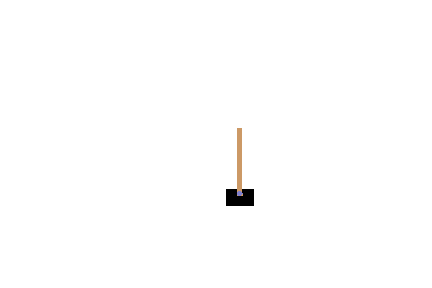
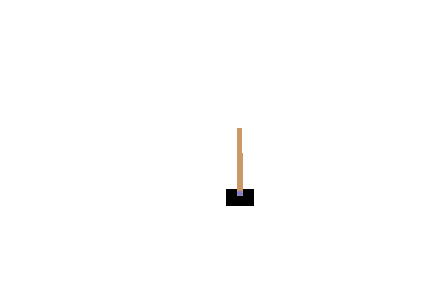
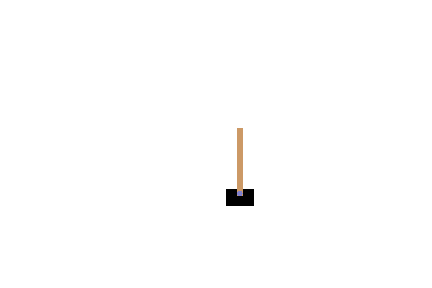
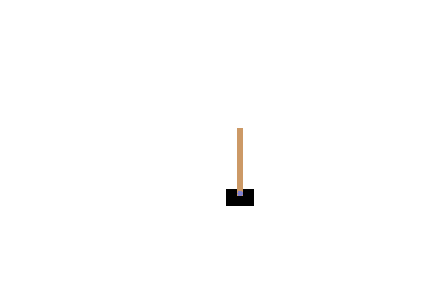
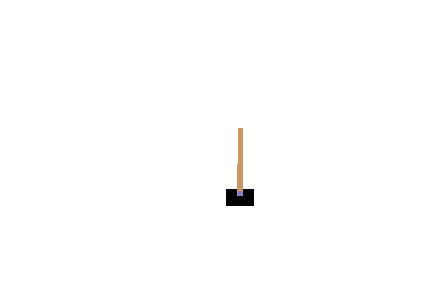
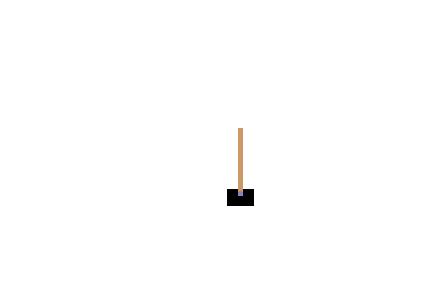
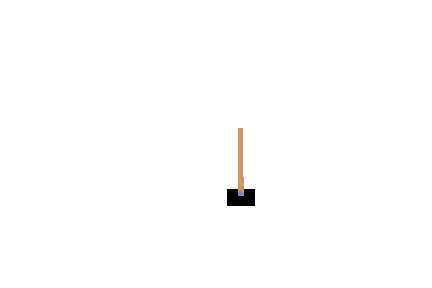
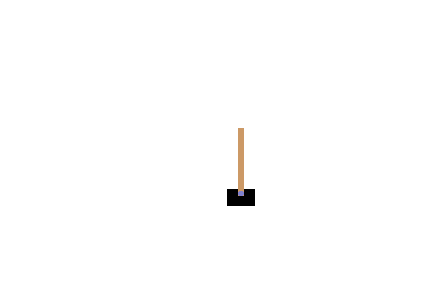
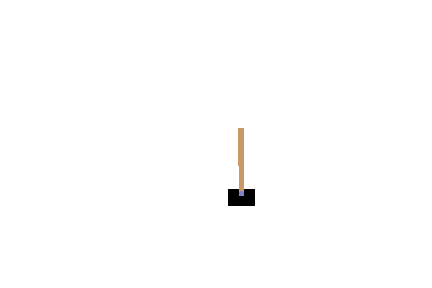
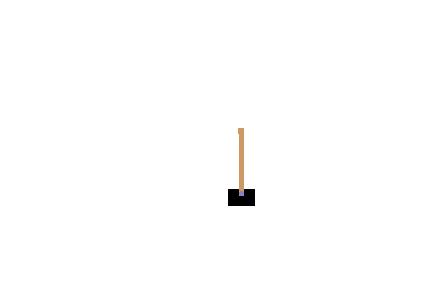
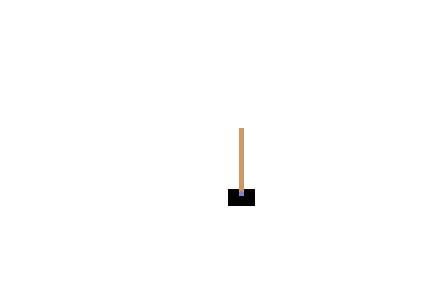
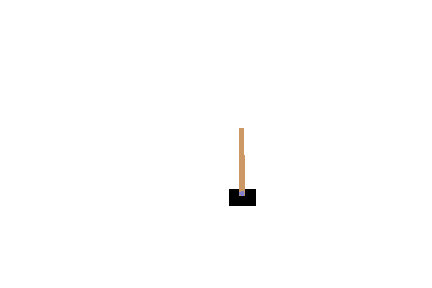
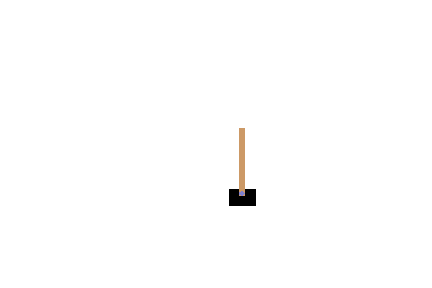
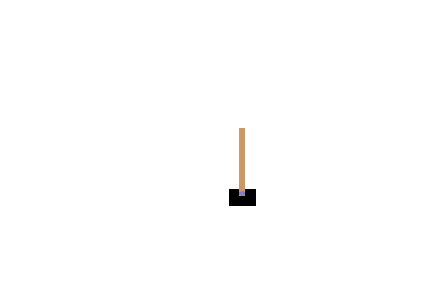
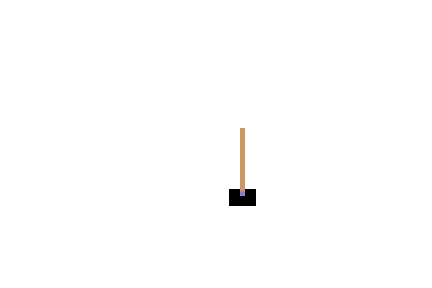
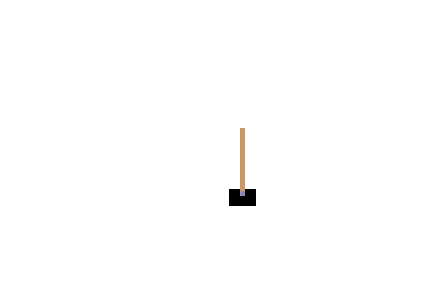
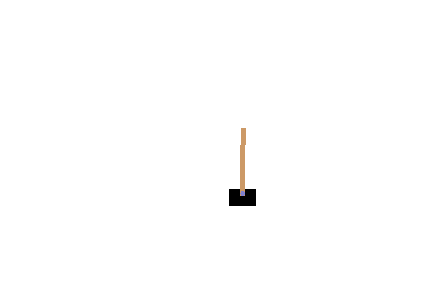
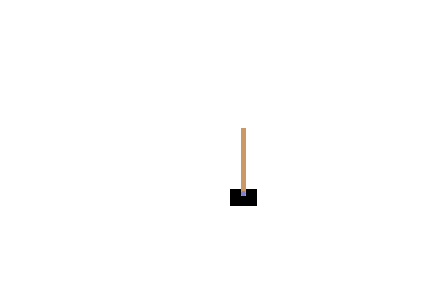
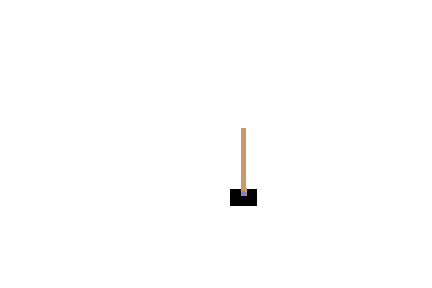
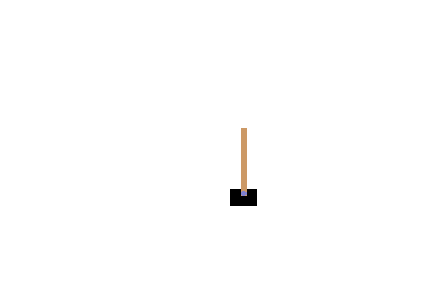
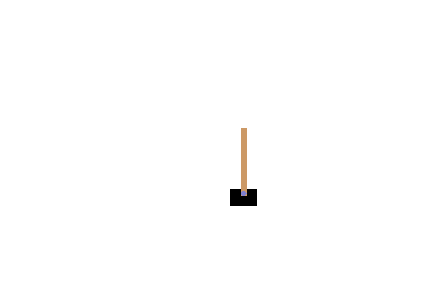
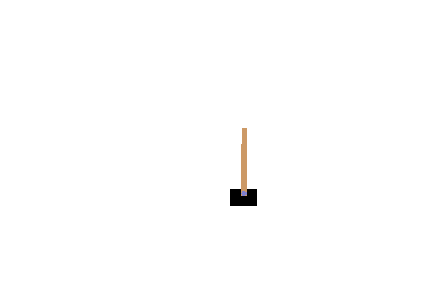
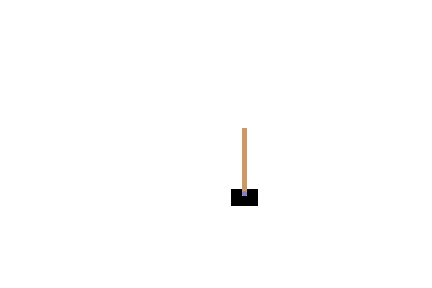
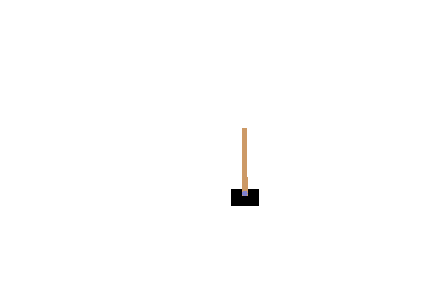
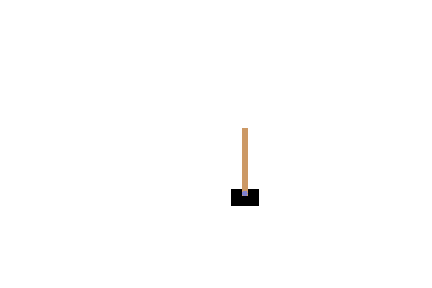
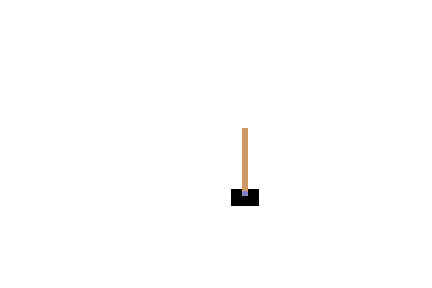
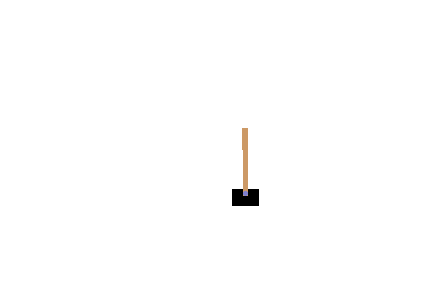
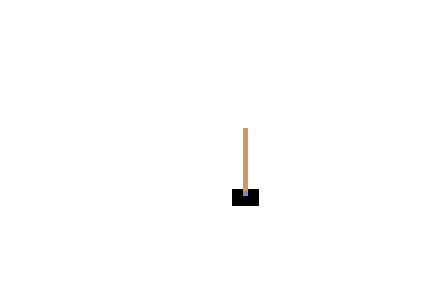
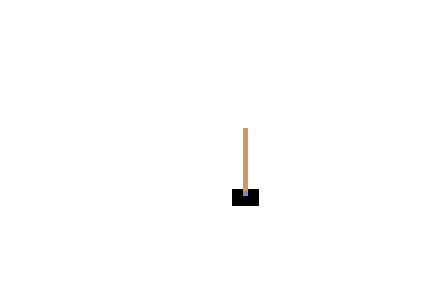
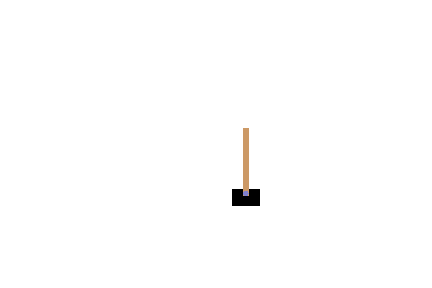
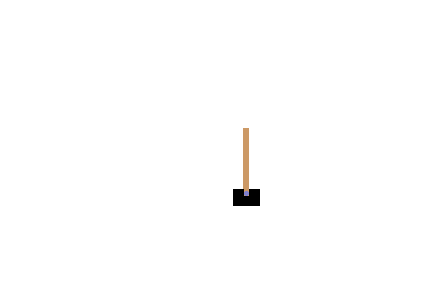
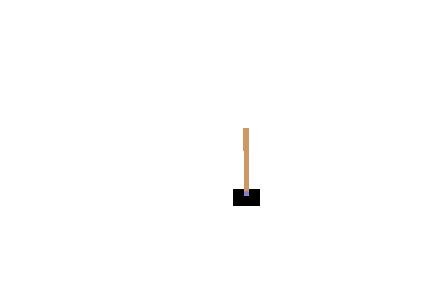
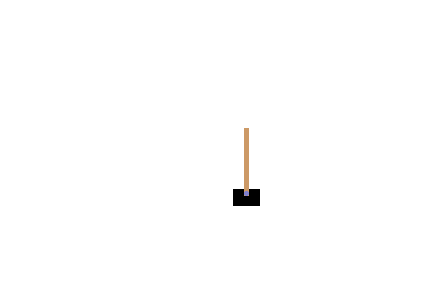
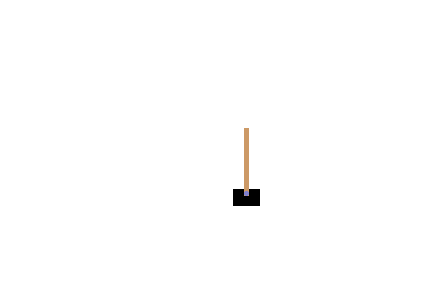
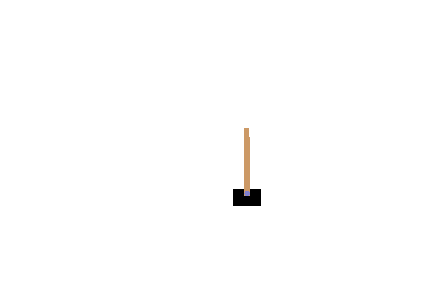
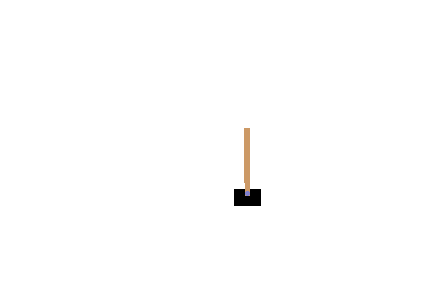
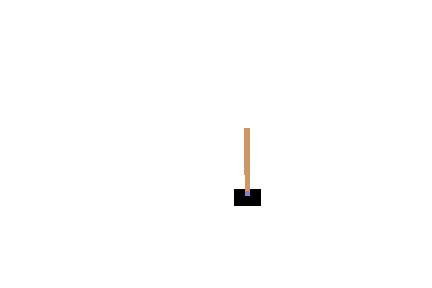
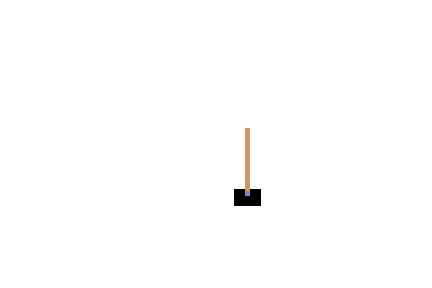
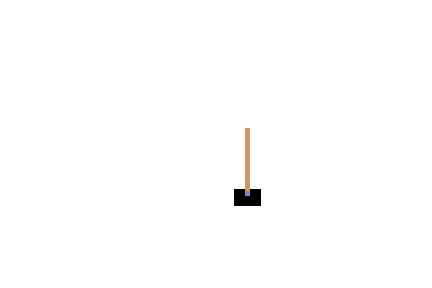
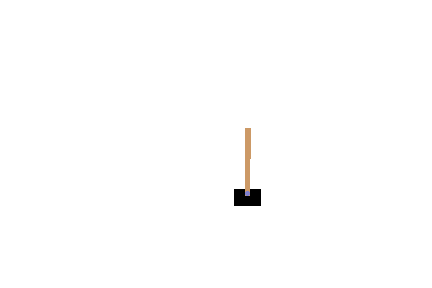
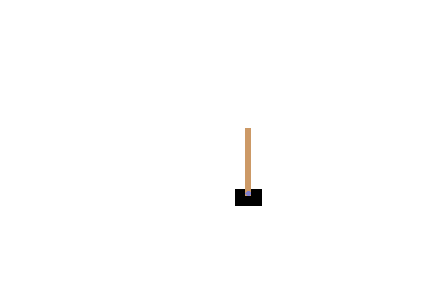
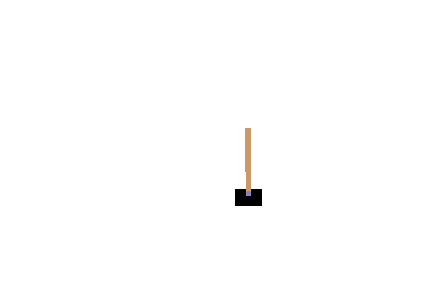
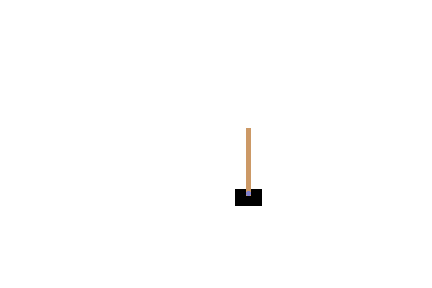
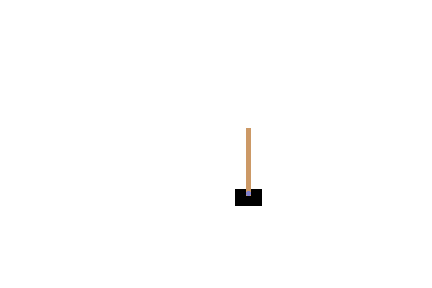
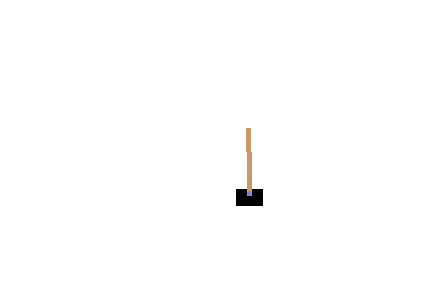
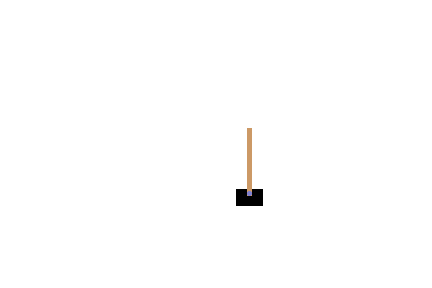
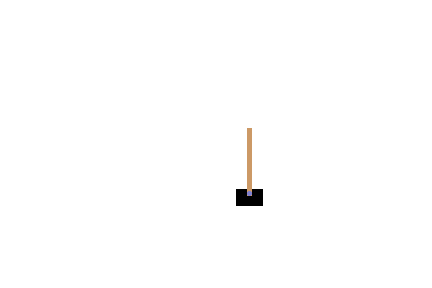
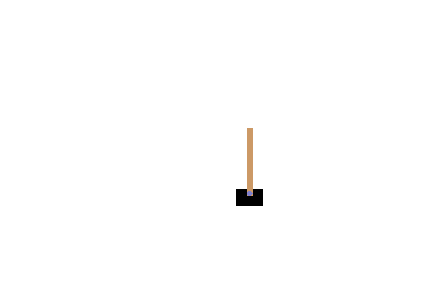
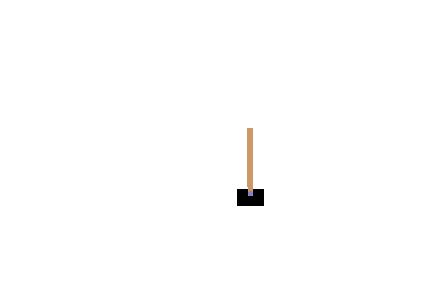
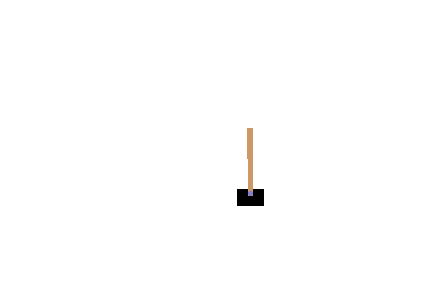
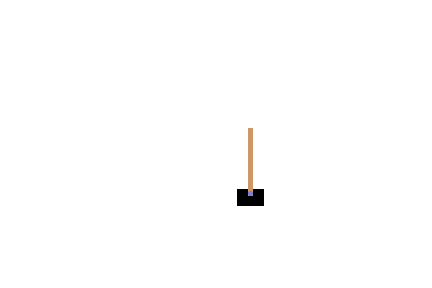
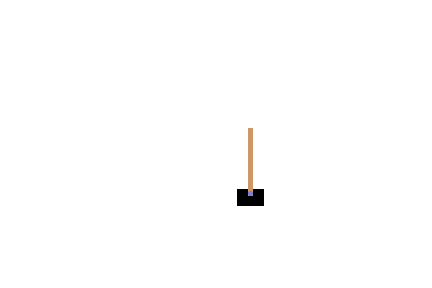
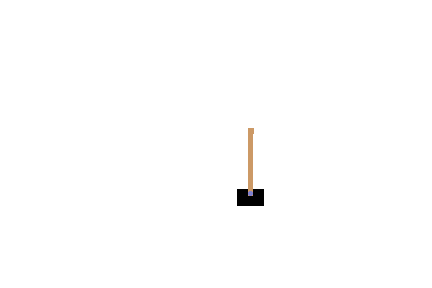
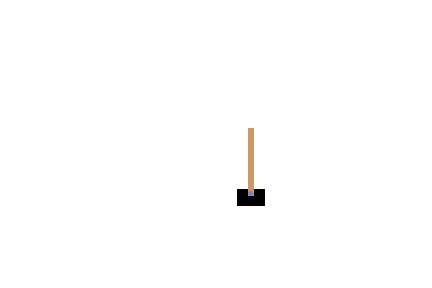
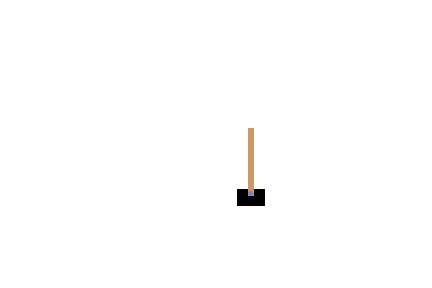
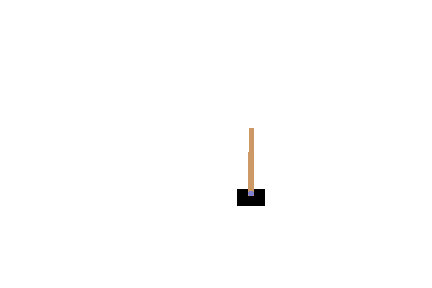
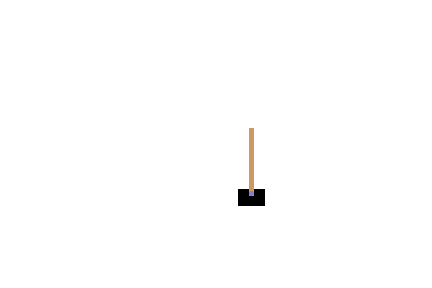
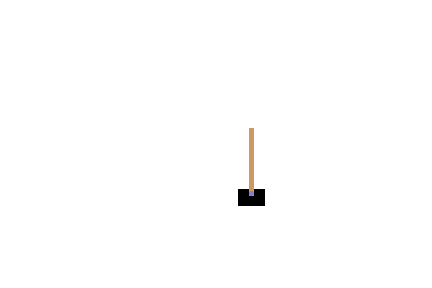
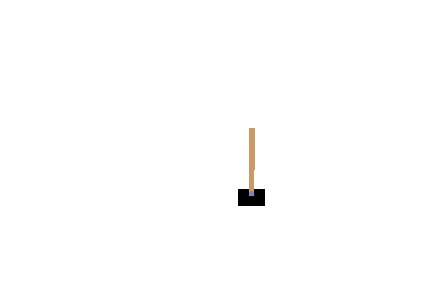
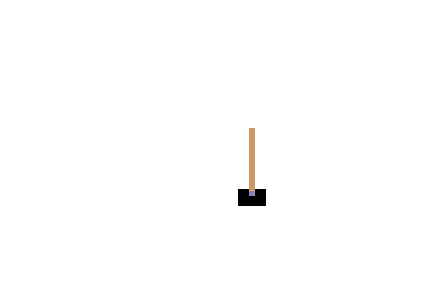
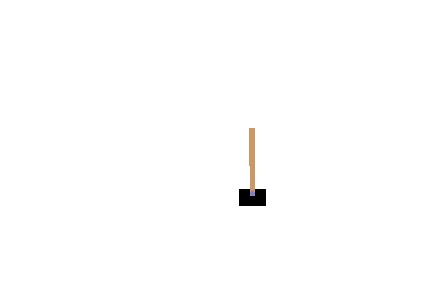
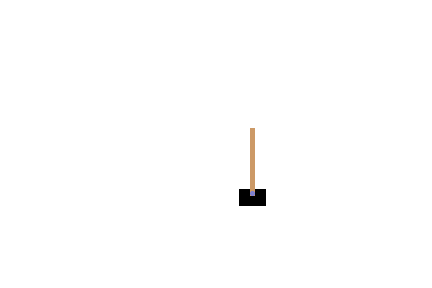
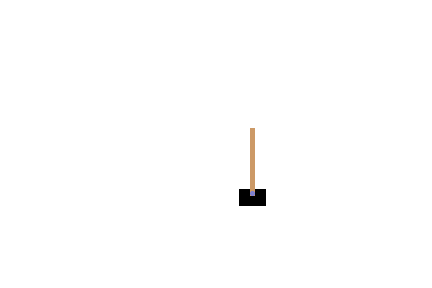
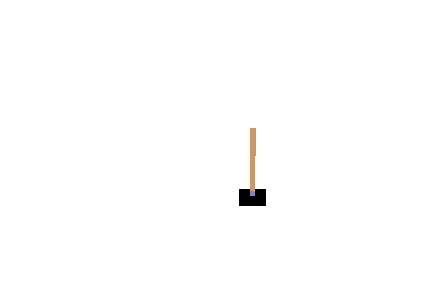
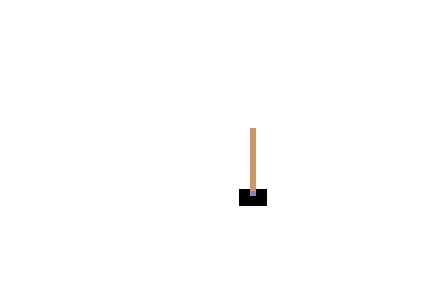
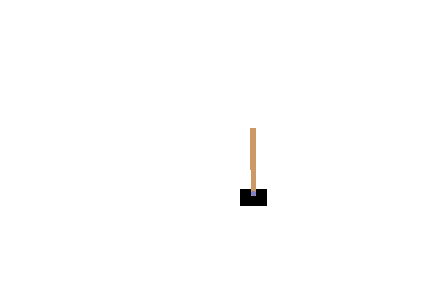
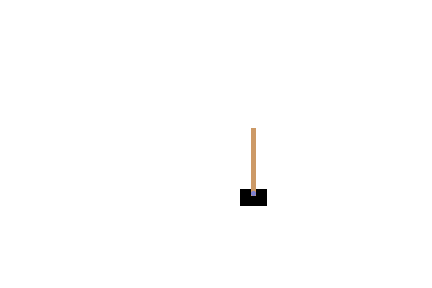
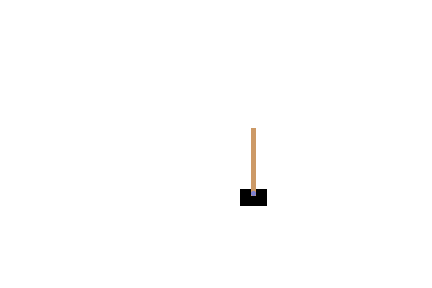
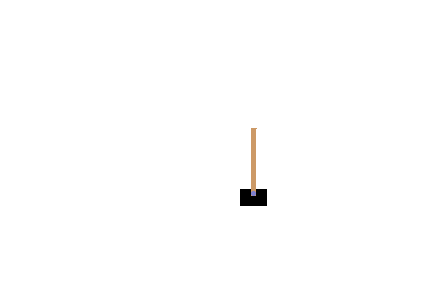
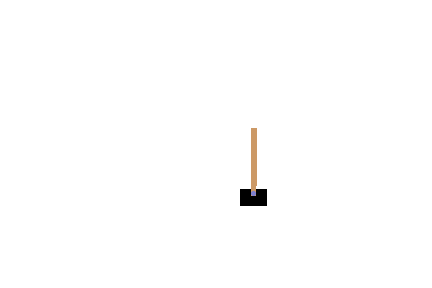
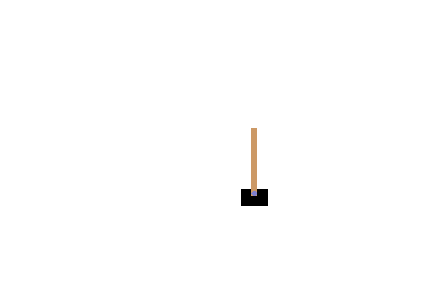
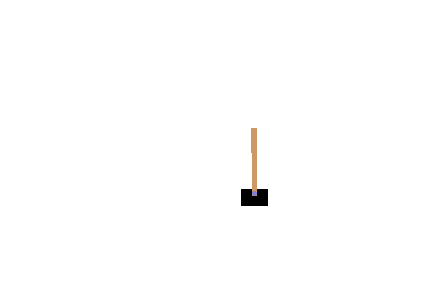
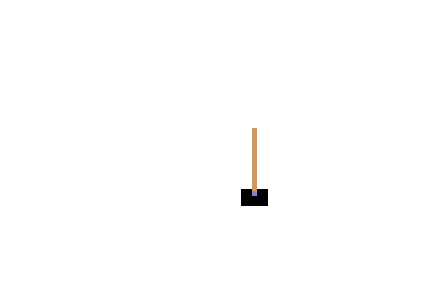
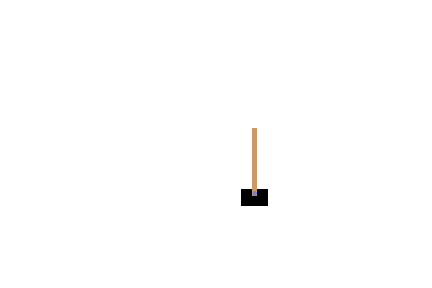
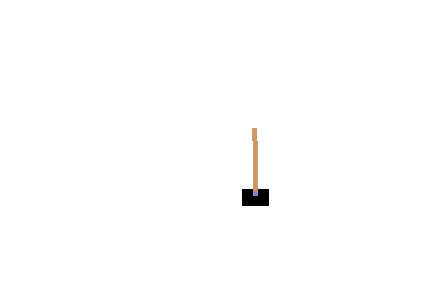
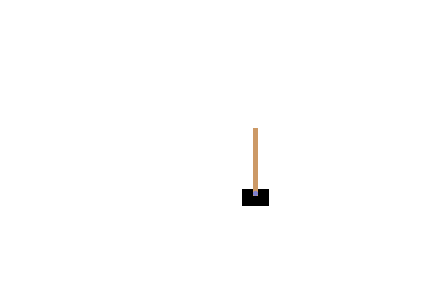
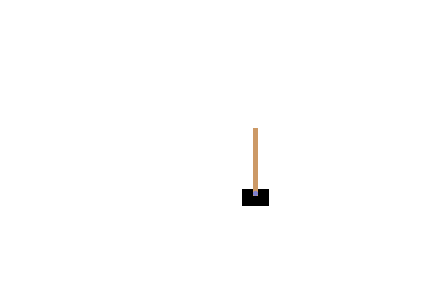
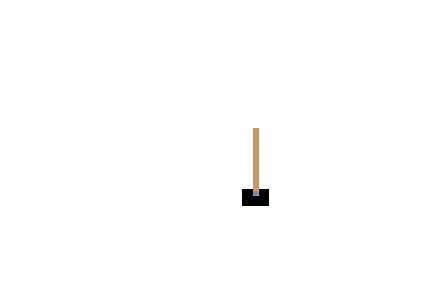
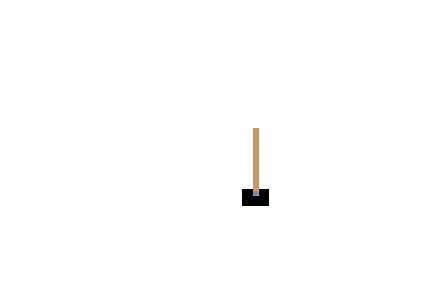
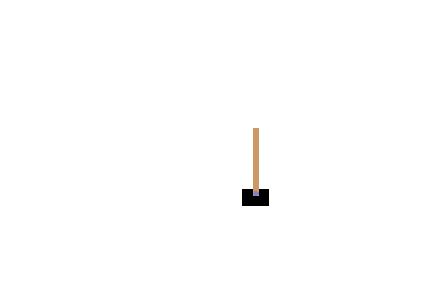
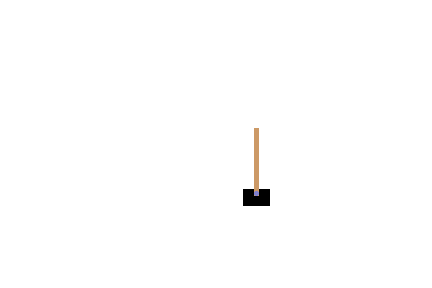
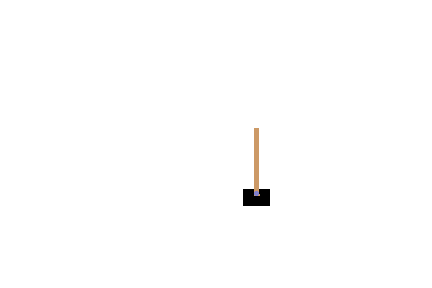
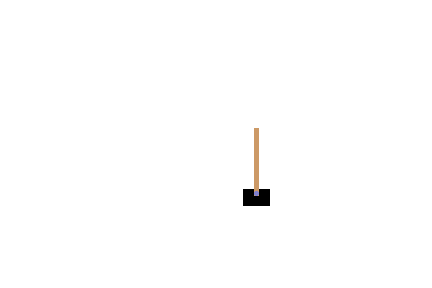
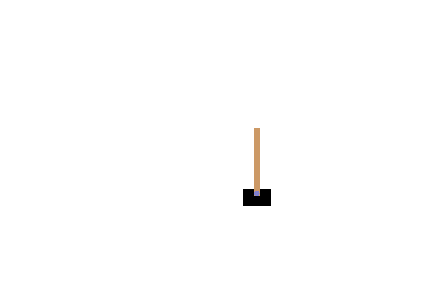
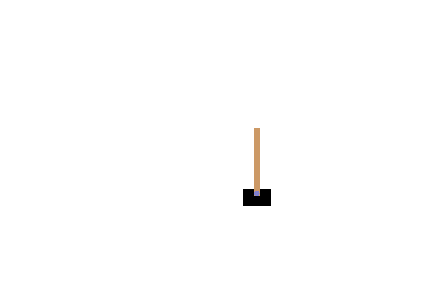

In [22]:
e.test(d)